# Categorise Bank Transactions

# Introduction

This bank transactions dataset consists of 2 accounts' 894 transaction record across 3-month period for each account, where the first accountId had 499 transaction records and the second accoundId had 395 records. Each transaction record consists of 4 features with no target class labels:

| Feature | Data type | Value |
|----|--|--|
| Transaction record posted datetime | datetime | yyyy-mm-dd 00:00:00, e.g 2021-09-29 00:00:00 |
| TransactionStatus | text | "DEBIT" and "CREDIT" |
| TransactionDescription | text | short description, including receipt, business, datetime, card or other information |
| TransactionAmount | float | positive and negative float values, e.g 15.9, -300 |

The aim of this analysis is to classify each transaction record to one of the following 5 categories:
- Salary
- Restaurant (Eating out)
- Cafe
- Transfer
- Grocery



Adopted approaches and high level workflow of this work are shown below:

![solution](https://github.com/ericwanga/categorise-bank-transaction/blob/main/img/solution.jpg?raw=true)

1. Preprocess and clean raw data and text documents
2. Based on full records, unsupervised learning methods
 - Hierarchical clustering
 - KMeans clustering
 - Document vector to Label vector cosine similarity model
3. Based on business understanding, preliminarily assign labels to dataset where we are sure about, which will cover 59% of all transaction records
4. Based on the 59% labelled data, semi-supervised methods to build below classifiers, and use them to predict unknown 41% records
 - machine learning model, Random Forest, on TF-IDF vectors and document vectors respectively
 - RNN model, Bidirectional LSTM, on embedded vectors
 - Transformer Encoder model, on embedded vectors

# Load and setup

In [1]:
# load
# essentials
import datetime
from time import time
#from datetime import date
import json
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm #colormap for plotting silhouettte
import seaborn as sns

# for clustering
import scipy.cluster.hierarchy as sch
# for Elbow method to find optimal num of cluster
from yellowbrick.cluster import KElbowVisualizer # failed to luanch after a recent Windows update, finding solution

# for ML model & metrics
from sklearn.preprocessing import RobustScaler, label_binarize, LabelBinarizer # for scaling and label encoding
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import VarianceThreshold # for variance filtering of features
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,cohen_kappa_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve,auc
from sklearn.metrics import recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# for DL model & metric
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow_addons as tfa # cohen_kappa is in tf addons

# for text processing, lda model, and vector similarity model
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
from gensim.models import doc2vec, ldamodel
import gensim.downloader as gensim_api
from lbl2vec import Lbl2Vec

In [2]:
# setup
pd.set_option('display.max_colwidth', 100)
# instantiate scaler
rscaler = RobustScaler()
# prepare a storage for results
storage = {}

# Utilities

In [3]:
# utilities

# define text cleaning to remove numbers, in-string datetime (after feature extraction), and other cleaning
def util_initialclean(text):
    text = text.replace(r'*', ' ')
    text = text.replace(r'- ', '')
    text = text.replace(r',', '')
    text = text.replace(r'.com', '')
    text = re.sub('receipt (.{6})', '', text)
    text = re.sub('date (.{8})', '', text)
    text = re.sub('card (.{4})', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub('\S*\d\S*','', text) # remove numbers
    text = text.replace(r'/', ' ')
    text = text.casefold()
    return text


# preprocess to word tokens, with stopwords, stemming, lemmatization options
def util_preprocess_to_list(text, rm_stopwords=True, stem=False, lemm=False):
    # define
    ps = PorterStemmer()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    text = text.strip()
    
    # remove punctuation
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    #tokens = re.split('\W+', text) # alternative
    
    #stems = [ps.stem(w) for w in text.split(' ')]
    if rm_stopwords == True:
        tokens = [word for word in tokens if word not in stop_words]
    if stem == True:
        #text = [word for word in stems if word not in stop_words]
        tokens = [ps.stem(word) for word in tokens]
    if lemm == True:
        tokens = [lem.lemmatize(word) for word in tokens]
    
    return tokens # return a list of words, not sentence


# preprocess text to document, and provide stopwords removal, stemming, and lemmatization options
def util_preprocess_to_sentence(text, rm_stopwords=True, stem=False, lemm=False):
    # define
    ps = PorterStemmer()
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    stop_words = stopwords.words('english')

   # text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split()
    
    if stopwords == True:
        lst_text = [word for word in lst_text if word not in stop_words]
    if stem == True:
        lst_text = [ps.stem(word) for word in lst_text]
    if lemm == True:
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # to sentence
    text = ' '.join(lst_text)
    
    return text # return a complete sentence, not in list
    #return lst_text

    
# silouhette plot for kmeans clusters
def plot_silhouette_for_kmeans_clusters(X, cluster):
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(X)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i)/n_clusters)

        ax.fill_betweenx(np.arange(y_lower, y_upper)
                          ,ith_cluster_silhouette_values
                          ,facecolor=color
                          ,alpha=0.7)

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=12, fontweight='bold')
    plt.show()
    
    
# simple tokenizer
def tokenize(doc):
    return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)


# find datetime info from string
def find_dates(dt):
    result = re.findall(r'\d{2}/\d{2}/\d{2}', dt)
    return result


# remove multiple items from a list if exists for keywords enrichment
def remove_values_from_list(list_obj, values):
    for value in values:
        while value in list_obj:
            list_obj.remove(value)
            
            
# plot roc curve for multiclass classification
def plot_roc_for_multiclass_classification(model,xt,yt):
    '''
    Reference
    sklearn page: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    from itertools import cycle

    y_score = model.predict_proba(xt)
    y_test_bin = label_binarize(yt, classes=['cafe','groceries', 'restaurant', 'salary','transfer'])
    n_classes = y_test_bin.shape[1]

    # # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(
        fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:0.5f})".format(roc_auc["micro"]),
        color="deeppink", linestyle=":", linewidth=4,
    )
    plt.plot(
        fpr["macro"], tpr["macro"], label="macro-average ROC curve (area = {0:0.5f})".format(roc_auc["macro"]),
        color="navy", linestyle=":", linewidth=4,
    )
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i], tpr[i], color=color, lw=lw,
            label="ROC curve of class {0} (area = {1:0.5f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()
    
    
# plot metrics for RNN & BiLSTM model training
def plot_learning_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs", fontsize=10)
    plt.ylabel(metric, fontsize=12)
    plt.legend([metric, 'val_'+metric], fontsize=12)
    
    
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred,targetlabel, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    
    for (idx, c_label) in enumerate(targetlabel):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx], y_pred[:,idx]) # .astype(int)
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


# define embedding layer for TEncoder
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # , mask_zero=True
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    
# define Transformer block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    

# get similar words based on pretrained glove-wiki-gigaword-... embeddings, instantiated as nlp
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [153]:
# load data from json file
with open('bank_transactions.json', 'r') as f:
    data = json.load(f)

# pretty print to understand the structure
#print(json.dumps(data,indent=2,default=str))

How many accounts in the dataset?

In [5]:
print('{} account(s)'.format(len(data['Accounts'])))
# convert to dataframe for easy observation
pd.DataFrame.from_dict(data['Accounts'])

2 account(s)


,AccountId,FinancialInstitution,AccountNumber,AccountType,AccountName,AccountBsb,AccountHolderName,StatementFromDate,StatementToDate,OutstandingBalance,CurrentBalance,AvailableBalance,CreditLimit,Transactions
0,773edf8c-e78f-11ec-bd51-1a25830e1bc2,ING,555555555,TRANSACTION,Orange Everyday,100 100,Sample Account Holder 1,2021-10-01 00:00:00,2021-12-31 00:00:00,None,238.14,238.14,None,"[{'TransactionPostedOn': '2021-10-01 00:00:00', 'TransactionStatus': 'DEBIT', 'TransactionDescri..."
1,66b4e99a-e78f-11ec-bd51-1a25830e1bc2,ING,33333333,TRANSACTION,Orange Everyday,100 100,Account Holder Sample 2,2022-01-01 00:00:00,2022-03-31 00:00:00,None,195.25,195.25,None,"[{'TransactionPostedOn': '2022-01-01 00:00:00', 'TransactionStatus': 'CREDIT', 'TransactionDescr..."


- 2 accounts in this dataset

How many transactions for each account? What's in a transaction record?

In [6]:
for x in data['Accounts']:
    print('{} transactions'.format(len(x['Transactions'])))
    for y in x['Transactions']:
        print('Strucutre:\n', y.keys())
        break

499 transactions
Strucutre:
 dict_keys(['TransactionPostedOn', 'TransactionStatus', 'TransactionDescription', 'TransactionAmount'])
395 transactions
Strucutre:
 dict_keys(['TransactionPostedOn', 'TransactionStatus', 'TransactionDescription', 'TransactionAmount'])


- 894 transactions in total
- 4 features per `Transactions` record

# Preprocess data

## Refactor

Refactor `Transactions` to dataframe with keys as columns, plus the `AccountId` as identifier

In [7]:
# create transaction dataframe for each account and append together
df = pd.DataFrame()
for x in data['Accounts']:
    tmp = pd.DataFrame.from_dict(x['Transactions'])
    tmp.insert(0, 'AccountId', x['AccountId'])
    df = df.append(tmp)
df['TransactionPostedOn'] = df['TransactionPostedOn'].astype('datetime64[ns]') # set type
df['TransactionStatus'] = df['TransactionStatus'].str.casefold() # to lower case
df['TransactionDescription'] = df['TransactionDescription'].str.casefold() # to lower case
df = df.reset_index(drop=True) # reset index

print('Shape: {}'.format(df.shape))
df.head()

Shape: (894, 5)


,AccountId,TransactionPostedOn,TransactionStatus,TransactionDescription,TransactionAmount
0,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164427 sfs nrah sushi sushi adelaide date 29/09/21 card 8322,-6.50
1,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164428 viet hoa restaurant woodville ga date 29/09/21 card 3689,-46.00
2,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164429 costco wholesale aus kilburn date 29/09/21 card 3689,-875.88
3,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164430 frewville cafe baker frewville date 29/09/21 card 3689,-16.00
4,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322,-52.62


Check duplicates

In [8]:
# check duplicates
print('{} duplicate(s)'.format(df.duplicated().sum()))
df[df.duplicated(keep=False)]

1 duplicate(s)


,AccountId,TransactionPostedOn,TransactionStatus,TransactionDescription,TransactionAmount
559,66b4e99a-e78f-11ec-bd51-1a25830e1bc2,2022-01-17,credit,transfer from kippax pty ltd - receipt 49684449,986.32
583,66b4e99a-e78f-11ec-bd51-1a25830e1bc2,2022-01-17,credit,transfer from kippax pty ltd - receipt 49684449,986.32


In [9]:
# drop duplicate
df.drop_duplicates(inplace=True)

Duplicate removed.

Check NA

In [10]:
# check NA
df.isna().sum()

AccountId                 0
TransactionPostedOn       0
TransactionStatus         0
TransactionDescription    0
TransactionAmount         0
dtype: int64

No missing values

In [11]:
df.shape

(893, 5)

## Explore

Explore 3 features: transaction posted datetime, status, amount.

2022-02-17    15
2021-11-24    14
2022-03-24    13
2021-11-11    13
2021-10-01    12
              ..
2022-01-26     1
2021-12-11     1
2022-01-16     1
2022-03-29     1
2021-12-26     1
Name: TransactionPostedOn, Length: 176, dtype: int64


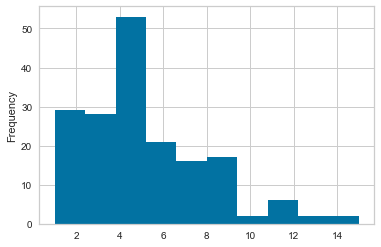

In [12]:
# TransactionPostedOn
print(df.TransactionPostedOn.value_counts())
df.TransactionPostedOn.value_counts().plot(kind='hist')
plt.show()

- 1 or multiple transactions per day
- datetime info might be repeated across multiple transactions

Explore transaction amount by known labels

In [13]:
# TransactionAmount
df.describe([0,0.01,0.1,0.25,0.5,0.75,0.9,0.99,1]).T

,count,mean,std,min,0%,1%,10%,25%,50%,75%,90%,99%,100%,max
TransactionAmount,893.0,25.463953,6356.779192,-130000.0,-130000.0,-1540.0,-147.8,-47.0,-16.4,-3.85,274.8,2001.39,130000.0,130000.0


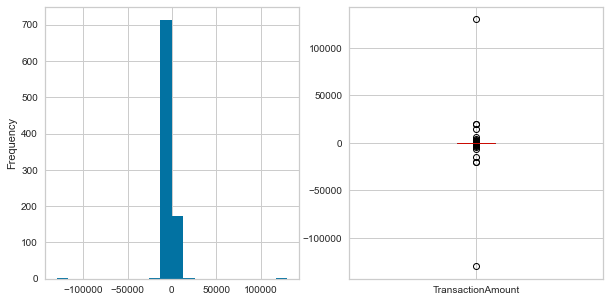

In [14]:
# TransactionAmount distribution
fig, axes = plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
df.TransactionAmount.plot(kind='hist',bins=20)
plt.subplot(1,2,2)
df.TransactionAmount.plot(kind='box')
plt.show()

- wide range of transaction amounts, possibly consists of smaill expenditures of daily expense, and large values of transfer or salary
- outliers are actual transactions amounts, no preprocess needed, but consider median values to represent the average

Explore transaction amount by status

In [15]:
# how many TransactionStatus by Status?
print('Counts of\n{}'.format(df.TransactionStatus.value_counts()))

# what are the ranges of the two TransactionStatus?
df.groupby('TransactionStatus').agg({'TransactionAmount': [min,max]})

Counts of
debit     717
credit    176
Name: TransactionStatus, dtype: int64


TransactionAmount          
                                min       max
TransactionStatus                            
credit                         0.01  130000.0
debit                    -130000.00      -0.6

Noticed below pattern
- all `CREDIT` transactions have positive values, i.e account receiving
- all `DEBIT` transactions have negative values, i.e account expending

In [16]:
# what are the average amounts by status, and their deviation
df.groupby('TransactionStatus').agg({'TransactionAmount': [np.median,np.std]})

TransactionAmount              
                             median           std
TransactionStatus                                
credit                       300.00  10037.916314
debit                        -24.02   5001.253641

Explore salary transactions

In [17]:
# # how many salary transactions?
# Status=Credit & description contains “salary”
df_salary = df.loc[(df['TransactionDescription'].str.contains('salary')) &
       (df['TransactionStatus'] == 'credit')
       , ['TransactionPostedOn','TransactionStatus','TransactionAmount','TransactionDescription']]

print("\nSalary transactions\n{}".format(df_salary.shape[0]))
df_salary


Salary transactions
7


,TransactionPostedOn,TransactionStatus,TransactionAmount,TransactionDescription
17,2021-10-04,credit,2001.39,tictoc home loans salary
90,2021-10-18,credit,2001.39,tictoc home loans salary
158,2021-11-01,credit,2001.39,tictoc home loans salary
247,2021-11-15,credit,2001.39,tictoc home loans salary
320,2021-11-29,credit,2001.39,tictoc home loans salary
396,2021-12-13,credit,2001.39,tictoc home loans salary
420,2021-12-16,credit,0.78,internal transfer save salary - receipt 193278


Salary transactions have consistent description formats and with "salary" being a keyword

## Known Matching

Consider the nature of receiving positive amount of money, `CREDIT` type of transactions are highly unlikely to fall into *Restaurant, Cafe, Groceries* categories, but rather *Transfer* or *Salary*. Even in scenarios of receiving refund from a restaurant, a cafe or a grocery store, these scenarios shall still be categorised as transfer type, instead of any expenditure types. 

Apart from positive amount transactions, all negative amount transactions without a keyword *Transfer* in the description will be treated as expenditures of other categories (*Restaurant, Cafe, Groceries*).

`Salary` is a keyword that will not occur in normal transaction descriptions except for actual salary payments from employer or self-adjustment that on-purposely added the word *salary* into description. It makes sense to treat descriptoins where keyword="salary" and amount being positive value as Salary type.

Based on above observation, we will initially set below labels:
- find keyword *Salary* in description and status=*Credit* to set label **Salary** 
- find `CREDIT` transactions status except for the Salary as label **Transfer**
- based on known transfer keyword list in descrition and status=`DEBIT` to set label **Transfer**

Based on most common knowledge, we will set below labels:
- based on known restaurant name list to set **Restaurant**
- based on known Cafe name list to set **Cafe**
- based on known grocery name list to set **Groceries**

In [18]:
# initiate
df['myLabel'] = None

# known transfer keyword list
lst_transfer = ['transfer','deposit','withdrawal','fee','credit','bill','bpay','payment']
# set Transfer
df.loc[df['TransactionStatus'] =='credit', 'myLabel'] = 'transfer'
df.loc[(df['TransactionStatus'] == 'debit') & 
       (df['TransactionDescription'].str.contains('|'.join(lst_transfer))), 'myLabel'] = 'transfer'

# set Salary
df.loc[(df['TransactionDescription'].str.contains('salary')) &
       (df['TransactionStatus'] == 'credit'), 'myLabel'] = 'salary'

# known restaurant keyword list
lst_restaurant = ['restaurant','kfc','mcdonalds','hungry','jacks', 'sushi','fish']
# set Restaurant
df.loc[df['TransactionDescription'].str.contains('|'.join(lst_restaurant)), 'myLabel'] = 'restaurant'

# known cafe keyword list
lst_cafe = ['cafe','coffee','baker','bakery','bakers','cheese','cake']
# set Cafe
df.loc[df['TransactionDescription'].str.contains('|'.join(lst_cafe)), 'myLabel'] = 'cafe'

# known grocery keyword list
lst_groceries = ['grocer','grocery','costco','coles','woolworths','foodland','otr'
                 ,'mart','kmart','ikea','big w','aldi','bunnings','target','pharmacy']
# set Groceries
df.loc[df['TransactionDescription'].str.contains('|'.join(lst_groceries)), 'myLabel'] = 'groceries'

# known matching summary
print('Known Matching labels:\n{}'.format(df['myLabel'].value_counts()))
df.head()

Known Matching labels:
transfer      257
groceries     207
restaurant     34
cafe           26
salary          7
Name: myLabel, dtype: int64


,AccountId,TransactionPostedOn,TransactionStatus,TransactionDescription,TransactionAmount,myLabel
0,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164427 sfs nrah sushi sushi adelaide date 29/09/21 card 8322,-6.50,restaurant
1,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164428 viet hoa restaurant woodville ga date 29/09/21 card 3689,-46.00,restaurant
2,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164429 costco wholesale aus kilburn date 29/09/21 card 3689,-875.88,groceries
3,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164430 frewville cafe baker frewville date 29/09/21 card 3689,-16.00,cafe
4,773edf8c-e78f-11ec-bd51-1a25830e1bc2,2021-10-01,debit,visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322,-52.62,None


In [19]:
# summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893 entries, 0 to 893
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   AccountId               893 non-null    object        
 1   TransactionPostedOn     893 non-null    datetime64[ns]
 2   TransactionStatus       893 non-null    object        
 3   TransactionDescription  893 non-null    object        
 4   TransactionAmount       893 non-null    float64       
 5   myLabel                 531 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 48.8+ KB


After Known Matching, 531 transactions (59%) are labelled. 

## What can known matching tell us?

Using the labelled part of the dataset, we are interested in the average transaction amounts in each category. Considering the potential outliers, we will use median value to represent the average.

myLabel
cafe           -15.495
groceries      -28.740
restaurant     -14.775
salary        2001.390
transfer        30.000
Name: TransactionAmount, dtype: float64


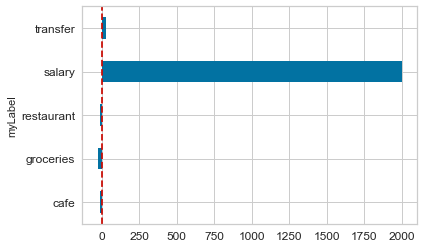

In [20]:
# Median Amount values in each category in labelled data
print(df.groupby('myLabel')['TransactionAmount'].median())
df.groupby('myLabel')['TransactionAmount'].median().plot(kind='barh', fontsize=12)
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

On average, *Transfer* and *Salary* transactions have positive values where other 3 categories have negative average amounts. Although this does not necessarily represent the entire population, but it brings up the foci of incorrectly classifying *Transfer* type would cause misleading representation of this account's expenditure activities. 

For example, the total expense under this account would have been decrease or increased because of mixing with wrong transfer values. Credit assessment would approve a loan value that's higher than the customer could afford (because of decreased expenses) or lower than customer expected (because of increased expenses).

Therefore, it makes sense that we focus on the **recall** metric of class *Transfer* and *Salary* because when a transaction is actually a transfer type, we particularly don't want the model to make wrong classifications of thses 2 types.

## Extract feature, clean, merge

Next, noticed datetime info sits in two places, we extract them from both description and TransactionPostedOn variable, transform and put back in description string. We then clean the description text and merge useful information together.

- Extract datetime info
 - weekday name
 - month
 - day
- clean text and remove receipt numbers, shop numbers, card numbers and other numbers
- Concatenate datetime

In [21]:
df_ = df.copy()

In [22]:
# extract datetime info to new columns
# if description contains datetime info, use it, otherwise, use TransactionPostedOn as datetime
df_['Time_'] = df_['TransactionDescription'].apply(lambda dt: find_dates(dt))
df_['Time'] = pd.to_datetime([','.join(map(str, l)) for l in df_['Time_']])
df_['Time'].fillna(df_['TransactionPostedOn'], inplace=True)
df_['weekday'] = df_['Time'].dt.day_name()
df_['month'] = df_['Time'].dt.month_name()
df_['day'] = df_['Time'].dt.day
df_.drop(columns=['Time_','Time'], inplace=True)

# clean text
# will clean datetime strings - this is why we extract them first in above step
df_['desc'] = df_['TransactionDescription'].apply(lambda x: util_initialclean(x))
df_['desc'] = df_['desc'].apply(lambda x: util_preprocess_to_sentence(x
                                           ,rm_stopwords=True
                                          ,stem=False 
                                          ,lemm=False))

# concatenate clean text with new datetime columns and drop other cols
cols = df_.columns[[9,6,7,8]].tolist()
df_['clean_text'] = df_[cols].fillna('').astype(str).apply(' '.join, axis=1)
df_.drop(df_.columns[[1,2,6,7,8,9]].tolist(), axis=1, inplace=True) 
df_.head()

,AccountId,TransactionDescription,TransactionAmount,myLabel,clean_text
0,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164427 sfs nrah sushi sushi adelaide date 29/09/21 card 8322,-6.50,restaurant,visa purchase sfs nrah sushi sushi adelaide Wednesday September 29
1,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164428 viet hoa restaurant woodville ga date 29/09/21 card 3689,-46.00,restaurant,visa purchase viet hoa restaurant woodville ga Wednesday September 29
2,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164429 costco wholesale aus kilburn date 29/09/21 card 3689,-875.88,groceries,visa purchase costco wholesale aus kilburn Wednesday September 29
3,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164430 frewville cafe baker frewville date 29/09/21 card 3689,-16.00,cafe,visa purchase frewville cafe baker frewville Wednesday September 29
4,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322,-52.62,None,visa purchase dbs linden park primar linden park Thursday September 30


In [23]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893 entries, 0 to 893
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AccountId               893 non-null    object 
 1   TransactionDescription  893 non-null    object 
 2   TransactionAmount       893 non-null    float64
 3   myLabel                 531 non-null    object 
 4   clean_text              893 non-null    object 
dtypes: float64(1), object(4)
memory usage: 41.9+ KB


In [24]:
# write to file
df_.to_csv('df_.csv')

# TF-IDF

![tfidf](https://github.com/ericwanga/categorise-bank-transaction/blob/main/img/tfidf.jpg?raw=true)

Use term frequency inverse document frequency to represent words, instead of count vectors, to better emphasize words that are more identifiable to its doc but not to other docs. Then these meaningful representations are sent to 2 clustering algorithms, hierarchical clustering and KMeans.

In clustering methods, we will use all data except for *Salary* type, treating it as a class that can be filtered out by strict business rule and keyword. The task is now a 4-class clustering.

In [36]:
#df_km = df_[df_['myLabel'] != 'salary'].reset_index(drop=True) # 4-class
df_km = df_[df_['myLabel'].isna()].reset_index(drop=True) # 4-class
#df_km = df_.copy()
df_km.shape

(362, 5)

In [37]:
tfidf = TFIDF(min_df=0).fit(df_km['clean_text'])
tfidf_result = tfidf.transform(df_km['clean_text'])
tfidf_result

<362x402 sparse matrix of type '<class 'numpy.float64'>'
	with 3095 stored elements in Compressed Sparse Row format>

In [155]:
print('Number of unique words: {}'.format(len(tfidf.vocabulary_)))

Number of unique words: 402


In [154]:
#tfidf.vocabulary_ # 'term': feature indices

# Hierarchical clustering

Computer data poinst Euclidean distance similarities in a bottom-up fashion. At this stage it is more useful for us to have an observation of their distribution. We try 3 linkage computations to cluster them. Ward to group by comparing sum of square before/after clustering attempts, average to group using avearge distance between 2 cluster attempts, and complete to group according to the farthest distance of the cluster attpemts.

In [39]:
# prep data
# scale TransactionAmount
df_km['Amount_scaled'] = rscaler.fit_transform(pd.DataFrame(df_km['TransactionAmount']))
# add scaled amount to tf-idf vectors
df_tfidf_hc = pd.DataFrame(tfidf_result.toarray(),columns=tfidf.get_feature_names_out()) # need to convert to dataframe
df_tfidf_hc = pd.concat([df_tfidf_hc,df_km['Amount_scaled'].reset_index(drop=True)], axis=1)

In [40]:
print(df_tfidf_hc.shape)
df_tfidf_hc.head()

(362, 403)


,10,11,12,13,14,15,16,17,18,19,...,whs,wingfield,woodv,woodville,ynde,yong,your,yville,zap,Amount_scaled
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.755670
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.656186
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.254091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113402
4,0.279297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461340


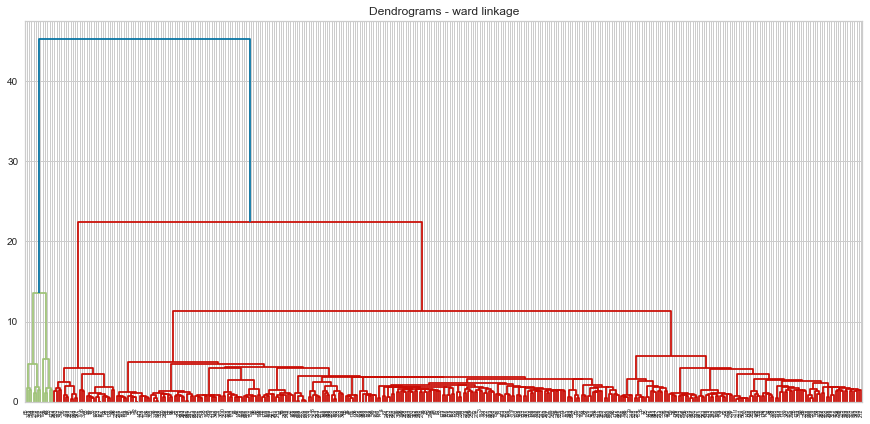

In [41]:
# hc with ward linkage
scaled_array = df_tfidf_hc.iloc[:, :]
Z = sch.linkage(scaled_array, method='ward')
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms - ward linkage")  
dend = sch.dendrogram(Z)

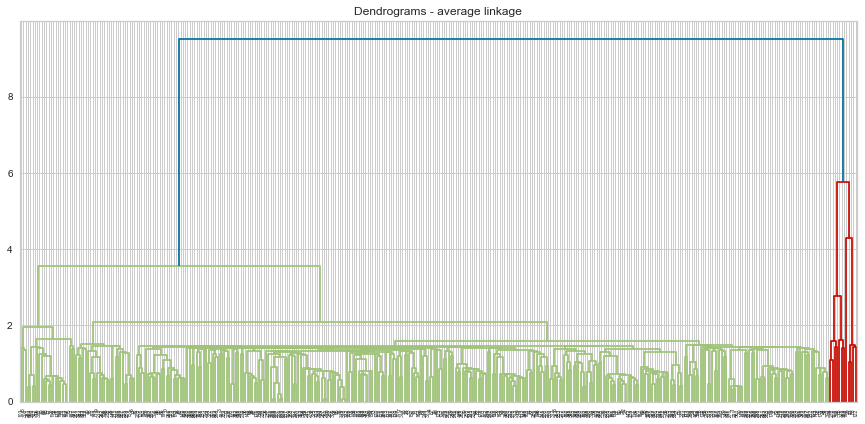

In [42]:
# hc with average linkage
scaled_array = df_tfidf_hc.iloc[:, :]
Z = sch.linkage(scaled_array, method='average')
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms - average linkage")  
dend = sch.dendrogram(Z)

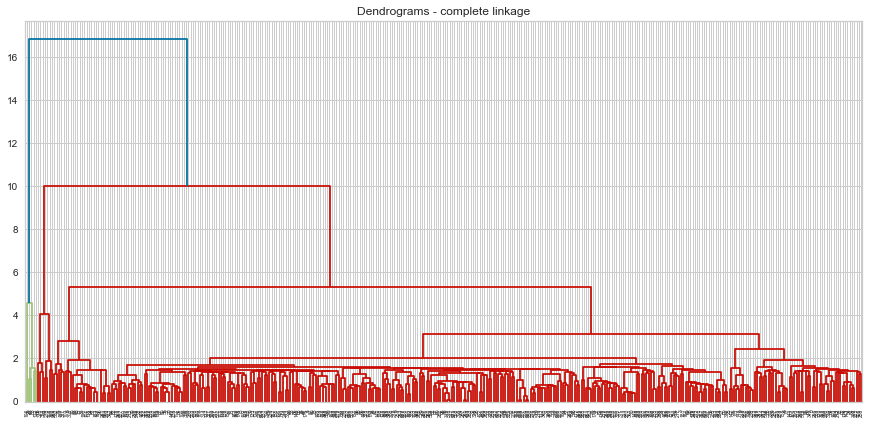

In [43]:
# hc with complete linkage
scaled_array = df_tfidf_hc.iloc[:, :]
Z = sch.linkage(scaled_array, method='complete')
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms - complete linkage")  
dend = sch.dendrogram(Z)

In [ ]:
# # hc with single linkage
# scaled_array = df_tfidf_hc.iloc[:, :]
# Z = sch.linkage(scaled_array, method='single')
# plt.figure(figsize=(15, 7))  
# plt.title("Dendrograms - single linkage")  
# dend = sch.dendrogram(Z)

Visual inspection, HC results suggested optimal number of clusters to be 2 or 3. Our expectation of 4 clusters does not seem to be easy clustering result from this approach, as neither linkage computation actually distinguishes majority of the data points. Next, we consider another clustering method KMeans to cross-check this unsupervised direction.

# KMeans on TF-IDF

## prep data

In [44]:
# add scaled amount to tf-idf vectors
df_tfidf_km = pd.DataFrame(tfidf_result.toarray(),columns=tfidf.get_feature_names_out()) # need to convert to dataframe
df_tfidf_km = pd.concat([df_tfidf_km,df_km['Amount_scaled'].reset_index(drop=True)], axis=1)
print(df_tfidf_km.shape)
df_tfidf_km.head()

(362, 403)


,10,11,12,13,14,15,16,17,18,19,...,whs,wingfield,woodv,woodville,ynde,yong,your,yville,zap,Amount_scaled
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.755670
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.656186
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.254091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113402
4,0.279297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461340


In [45]:
# example, the 7th document
df_km['clean_text'][6]

'visa purchase dodo services pty ltd melbourne Wednesday February 10'

In [46]:
# example, top 10 identifiable words in the 7th document
df_tfidf_km.T.nlargest(10,6)

,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,360,361
dodo,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.475094,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
services,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.475094,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
melbourne,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.342219,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.363601,0.000000,0.000000,0.000000,0.0
10,0.000000,0.000000,0.0,0.254091,0.279297,0.268704,0.338567,0.292634,0.311722,0.323083,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
february,0.000000,0.000000,0.0,0.000000,0.000000,0.231527,0.291724,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
wednesday,0.000000,0.191577,0.0,0.000000,0.220366,0.212008,0.267130,0.000000,0.000000,0.000000,...,0.000000,0.254195,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.243368,0.0
ltd,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.262271,0.000000,0.000000,0.000000,...,0.000000,0.249571,0.000000,0.000000,0.0,0.000000,0.290744,0.000000,0.000000,0.0
pty,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.257653,0.000000,0.000000,0.000000,...,0.000000,0.245177,0.000000,0.000000,0.0,0.000000,0.285625,0.000000,0.000000,0.0
visa,0.087812,0.000000,0.0,0.000000,0.097023,0.093343,0.117612,0.101656,0.108287,0.112234,...,0.000000,0.111917,0.109375,0.102811,0.0,0.124961,0.130381,0.119152,0.107151,0.0
purchase,0.079597,0.000000,0.0,0.080009,0.087946,0.084610,0.106609,0.092145,0.098156,0.101733,...,0.101265,0.101447,0.099142,0.093192,0.0,0.113270,0.118183,0.108005,0.097126,0.0


We have 403 converted features to represent each transaction.

## SVD

With 403 sparse feature dimensions, it is likely that their euclidean distances in such high-dimensional space got computed as close together, leading to one big chunk of cluster. Dimensionalities need to be reduced.

Use SVD, instead of PCA, to reduce dimensionality on sparse matrix, rather then reduce sparse to dense

In [47]:
svd = TruncatedSVD(n_components=200, random_state=420) # reduce dimensions to half

In [48]:
df_km_svd = pd.DataFrame(svd.fit_transform(df_tfidf_km))
print(df_km_svd.shape)
df_km_svd.head()

(362, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.759732,0.205814,-0.038051,-0.067358,0.332303,-0.165203,0.641064,-0.280005,-0.217680,-0.173655,...,0.014420,-0.002816,-0.001911,1.690349e-16,7.804298e-18,1.708112e-17,1.399884e-17,-3.208175e-17,1.899286e-17,-1.939816e-17
1,0.659059,0.050750,-0.028828,-0.028850,0.022601,-0.034392,-0.015930,0.031726,-0.081249,-0.031317,...,0.011696,-0.003197,0.002603,1.353084e-16,-2.276825e-17,2.255141e-17,1.387779e-17,-8.239937e-18,1.734723e-18,5.204170e-18
2,0.019730,0.235447,0.791544,0.213730,-0.071749,0.018387,0.079060,0.096279,-0.057776,-0.046152,...,0.009815,-0.009086,0.000878,2.428613e-17,1.387779e-17,2.081668e-17,6.938894e-18,1.040834e-17,1.561251e-17,-8.673617e-19
3,-0.111261,0.090307,-0.014059,-0.001286,0.089843,0.129900,-0.011763,-0.009834,-0.026777,-0.049797,...,-0.028029,0.005097,-0.000388,2.070162e-17,4.161739e-17,-5.216447e-17,-7.174886e-17,-3.116154e-17,-2.453309e-17,-5.590400e-18
4,-0.456336,0.153411,-0.022510,0.009658,0.063757,-0.050492,-0.078321,0.011606,-0.085660,0.003553,...,0.023371,-0.008523,-0.004101,1.734723e-17,3.989864e-17,-5.204170e-18,-3.816392e-17,9.540979e-18,-2.081668e-17,1.387779e-17


Before running KMeans, we can try to find a potential optimal number of clusters. We use Elbow point methods in here but there are other options too.

In [49]:
n_clusters = 4

In [50]:
# first, get a model
cluster_svd = KMeans(n_clusters=n_clusters,random_state=420).fit(df_km_svd)
#cluster_svd.inertia_

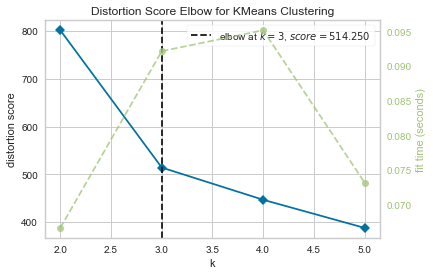

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# compare across 4 attemps (2,3,4,5) to observe a turning point
model = cluster_svd
visualizer = KElbowVisualizer(model, k=(2,6), timings= True)
visualizer.fit(df_tfidf_km.iloc[:,:])        # Fit data to visualizer
visualizer.show()

It is suggestied the optimal number of clusters of the dimension-reduced dataset (200 features) is 3, not as expected.

Proceed to run KMeans with pre-defined num_clusters =4, and visualize results. Use silhouette metric to measure the performance.

In [53]:
silhouette_score(df_km_svd, cluster_svd.labels_, metric='euclidean')

0.21394706672909375

For n_clusters = 4 The average silhouette_score is : 0.21394706672909375


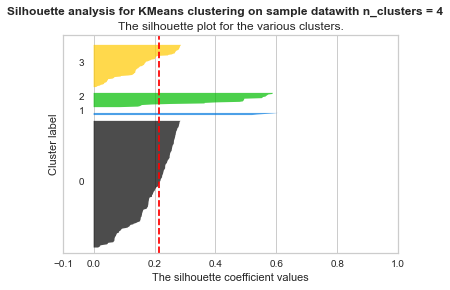

In [54]:
X = df_km_svd
clusterer = cluster_svd
plot_silhouette_for_kmeans_clusters(X, clusterer)

Although 4 clusters are distinguished, but low silouette score suggested strong overlappings that eventually would lead to multiple themed documents sits in one cluster. Instead of use SVD dimension reduction, try another way.

## Variance filtering

Filter out the 25% features with lowest variance, i.e. the values in these features are carrying the least amount of information.

In [55]:
# filter out 25% of features according lower variance
threshold = np.quantile(df_tfidf_km.var().values, 0.25)
selector = VarianceThreshold(threshold)
df_tfidf_var = selector.fit_transform(df_tfidf_km)
df_tfidf_var.shape

(362, 301)

In [56]:
cluster_var = KMeans(n_clusters=n_clusters,random_state=420).fit(df_tfidf_var)
# cluster_var.inertia_

In [57]:
silhouette_score(df_tfidf_var, cluster_var.labels_, metric='euclidean')

0.2557024186050833

For n_clusters = 4 The average silhouette_score is : 0.2557024186050833


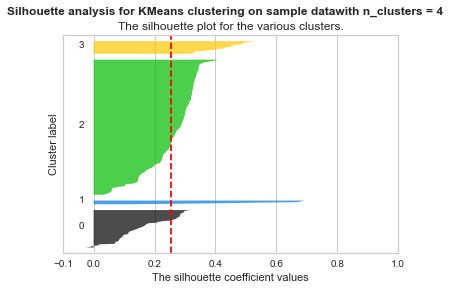

In [58]:
X = df_tfidf_var
clusterer = cluster_var
plot_silhouette_for_kmeans_clusters(X, clusterer)

Almost same as the previous model off SVD filtering. However, requesting KMeans to cluster to 4 classes, it could not distinguish any cluster, just simply treated almost all data points as 1 group. 

We then reduce the scope of records from full 886 records to those unlabelled records only and perform 4-class clustering. And to understand what is the optimal number of clusters within the unlabelled records, we use Elbow method to compare 2 to 5 clusters options

There are improvements in terms of finding clustered data points. However, low silhouette coefs, around 0.21, suggest overlapping across clusters. The interpretability of clustered documents will not be good.

In [59]:
# get the results
y_pred_var = cluster_var.labels_
df_km['labels_km'] = y_pred_var

In [60]:
df_km.head()

,AccountId,TransactionDescription,TransactionAmount,myLabel,clean_text,Amount_scaled,labels_km
0,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322,-52.62,None,visa purchase dbs linden park primar linden park Thursday September 30,-0.755670,0
1,773edf8c-e78f-11ec-bd51-1a25830e1bc2,"intl atmpurchase - receipt 164433 bigscoots, inc www.bigscoot foreign currency amount usd 34.95 ...",-48.76,None,intl atmpurchase bigscoots inc foreign currency amount usd Wednesday September 29,-0.656186,0
2,773edf8c-e78f-11ec-bd51-1a25830e1bc2,direct debit - receipt 152678 073053 ngtcraigm 75098090 to 838321094 014002,-23.30,None,direct debit ngtcraigm to Friday October 1,0.000000,2
3,773edf8c-e78f-11ec-bd51-1a25830e1bc2,eftpos purchase - receipt 004869 teamazing bubble te rwood date 04/10/21 card 8322,-18.90,None,eftpos purchase teamazing bubble te rwood Saturday April 10,0.113402,2
4,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 185431 jbm amusements evanston par date 03/10/21 card 8322,-5.40,None,visa purchase jbm amusements evanston par Wednesday March 10,0.461340,2


In [61]:
df_km.loc[df_km['labels_km'] == 3, 'clean_text'].head(10) # transfer?

5     visa purchase sport science podiatry eastwood Wednesday February 10
10                visa purchase seymour college glen osmond Monday May 10
17                     direct debit seymour college to Thursday October 7
33                    direct debit seymour college to Thursday October 14
48                    direct debit seymour college to Thursday October 21
63                    direct debit seymour college to Thursday October 28
74            direct debit discover energy discover to Tuesday November 2
81                    direct debit seymour college to Thursday November 4
94                   direct debit seymour college to Thursday November 11
96              visa purchase adidas australia mulgrave Monday October 11
Name: clean_text, dtype: object

In [62]:
df_km.loc[df_km['labels_km'] == 2, 'clean_text'].head(10) # groceries + transfer?

2                           direct debit ngtcraigm to Friday October 1
3          eftpos purchase teamazing bubble te rwood Saturday April 10
4         visa purchase jbm amusements evanston par Wednesday March 10
7            visa purchase sfs new royal adelai adelaide Monday May 10
8     visa purchase didichuxing didi mobility sydney Saturday April 10
11                  visa purchase crunchy bites adelaide Monday May 10
12        visa purchase the hoyts corporatio norwood Saturday April 10
13               visa purchase rahrf newsagency adelaide Monday May 10
14              visa purchase tony and marks glenside Thursday June 10
16                   direct debit debitssucessdf to Thursday October 7
Name: clean_text, dtype: object

In [63]:
df_km.loc[df_km['labels_km'] == 1, 'clean_text'].head(10) # transfer?

29              force post no funds state swim to Wednesday October 13
43                       direct debit state swim to Tuesday October 19
65                visa purchase centrelink sydney Wednesday October 27
83           eftpos purchase berkowitz furniture le end Tuesday May 11
106             visa purchase dit ezyreg adelaide Thursday November 11
122    visa purchase jetstar al ihkmpp charmaine.sk Friday November 19
318                            visa purchase afterpay Thursday March 3
354                 visa purchase deft strata sydney Thursday March 24
Name: clean_text, dtype: object

In [64]:
df_km.loc[df_km['labels_km'] == 0, 'clean_text'].head(10) # restaurant + transfer?

0                visa purchase dbs linden park primar linden park Thursday September 30
1     intl atmpurchase bigscoots inc foreign currency amount usd Wednesday September 29
6                   visa purchase dodo services pty ltd melbourne Wednesday February 10
9                         visa purchase next gen memorial dr north adelai Monday May 10
15                                      eftpos purchase hoi an lixstow Saturday July 10
25                          visa purchase health at dulwich dulwich Friday September 10
30                          visa purchase next gen taekwondo norwood Friday December 10
37                                   eftpos purchase hoi an lixstow Saturday October 16
45                   visa purchase next gen memorial dr north adelai Tuesday October 19
52                                   eftpos purchase hoi an lixstow Saturday October 23
Name: clean_text, dtype: object

Clusters did not clearly distinguish classes, and have mixed classes in one cluster. Visual inspection has seen enough evidence that HC and KMeans methods could not meet the our classification requirements.

# doc2vec

After the unsupervised methods, we proceed to semi-supervised methods. Classifiers will be built based on known labelled data. 

Here we first prepare the document vectors here to be used in next section of building machine learning models on top of it.

In [65]:
# use the labelled data from Known Matching step
df_d2v = df_.loc[df_['myLabel'].notna(), ['clean_text', 'myLabel']].reset_index(drop=True)
print(df_d2v.shape)
df_d2v.head()

(531, 2)


,clean_text,myLabel
0,visa purchase sfs nrah sushi sushi adelaide Wednesday September 29,restaurant
1,visa purchase viet hoa restaurant woodville ga Wednesday September 29,restaurant
2,visa purchase costco wholesale aus kilburn Wednesday September 29,groceries
3,visa purchase frewville cafe baker frewville Wednesday September 29,cafe
4,visa purchase target newton Thursday September 30,groceries


In [66]:
# requires list of words instead of sentence
df_d2v['clean_text'] = df_d2v['clean_text'].apply(lambda x: util_preprocess_to_list(x, rm_stopwords=True
                                                                              , stem=False
                                                                              , lemm=False
                                                                       ))
df_d2v.head()

,clean_text,myLabel
0,"[visa, purchase, sfs, nrah, sushi, sushi, adelaide, wednesday, september, 29]",restaurant
1,"[visa, purchase, viet, hoa, restaurant, woodville, ga, wednesday, september, 29]",restaurant
2,"[visa, purchase, costco, wholesale, aus, kilburn, wednesday, september, 29]",groceries
3,"[visa, purchase, frewville, cafe, baker, frewville, wednesday, september, 29]",cafe
4,"[visa, purchase, target, newton, thursday, september, 30]",groceries


In [67]:
#df_d2v['clean_text'] = df_d2v['clean_text'].apply(lambda x: simple_preprocess(x))
# split train, test sets
X_train, X_test, y_train, y_test = train_test_split(df_d2v['clean_text']
                                                    , df_d2v['myLabel']
                                                   , test_size=0.2
                                                   ,random_state=420)

In [68]:
# create tagged vectors as required by d2v model
tagged_doc_train = [doc2vec.TaggedDocument(v, [i]) 
                    for i, v in enumerate(X_train)]
tagged_doc_test = [doc2vec.TaggedDocument(v, [i]) 
                    for i, v in enumerate(X_test)]

In [69]:
# an example of tagged doc
tagged_doc_train[:1]

[TaggedDocument(words=['eftpos', 'purchase', 'family', 'mart', 'sa', 'firle', 'thursday', 'december', '16'], tags=[0])]

In [70]:
vsize = 50
d2v_model = gensim.models.Doc2Vec(tagged_doc_train
                                  , vector_size=vsize
                                  , window=5
                                  , min_count=2)

In [71]:
# example, infer_vector for 1 word, 
len(d2v_model.infer_vector(tagged_doc_train[0].words))

50

In [72]:
# go through tagged document sets to get vectorized train, test sets ready for use by ML models
X_train_d2v = [d2v_model.infer_vector(v.words) for v in tagged_doc_train]
X_test_d2v = [d2v_model.infer_vector(v.words) for v in tagged_doc_test]

In [73]:
# train set shape
len(X_train_d2v)

424

document vectors are ready to be used by ml models

# ML models on doc vec & tfidf vec

## The idea

**ML model on labelled --> predict unlabelled**

1. Based on Known Matching dataset from previous step (Section 4.3), split to train set and test set with ratio 0.8:0.2, build two models
 - RF model using doc vectors
 - RF model using tfidf matrix

2. Then use the models to predict unknown transactions (the rest of transactions after Known Matching labelling)

## RF models

In [74]:
# instanciate
rf_d2v = RandomForestClassifier(random_state=420)
rf_tfidf = RandomForestClassifier(random_state=420)

In [75]:
# prepare a separate dataset for tfidf 
# to aovid previous tfidf instances for KMeans
df_idf = df_.loc[df_['myLabel'].notna(), ['clean_text','TransactionAmount', 'myLabel']]
df_idf['clean_text'] = df_idf['clean_text'].apply(lambda x: util_preprocess_to_sentence(x, rm_stopwords=True
                                                                              , stem=False
                                                                              , lemm=False))
# same splitting ratio
Xtrain, Xtest, ytrain, ytest = train_test_split(df_idf['clean_text']
                                                    , df_idf['myLabel']
                                                   , test_size=0.2
                                                   ,random_state=420)

tfidf_ml = TFIDF().fit(Xtrain)
X_train_tfidf = tfidf_ml.transform(Xtrain)
X_test_tfidf = tfidf_ml.transform(Xtest)

In [76]:
print(df_idf.shape)
print(X_train_tfidf.shape)

(531, 3)
(424, 321)


In [77]:
rf_model_d2v = rf_d2v.fit(X_train_d2v, y_train.values.ravel())
rf_model_tfidf = rf_tfidf.fit(X_train_tfidf, y_train.values.ravel())

## Metrics

Obtain two models' confusion matrix and metrics

In [78]:
y_pred_d2v = rf_model_d2v.predict(X_test_d2v)
y_pred_tfidf = rf_model_tfidf.predict(X_test_tfidf)

In [79]:
# doc2vec
precision_d2v = precision_score(y_test, y_pred_d2v, average='micro')
recall_d2v = recall_score(y_test, y_pred_d2v, average='micro')
kappa_d2v = cohen_kappa_score(y_test, y_pred_d2v)
accu_d2v = (y_pred_d2v==y_test).sum()/len(y_pred_d2v)

In [80]:
# tfidf
precision_tfidf = precision_score(ytest, y_pred_tfidf, average='micro')
recall_tfidf = recall_score(ytest, y_pred_tfidf, average='micro')
kappa_tfidf = cohen_kappa_score(ytest, y_pred_tfidf)
accu_tfidf = (y_pred_tfidf==ytest).sum()/len(y_pred_tfidf)

In [81]:
# CM of RF on d2v
confusion_matrix(y_true=y_test, y_pred=y_pred_d2v)

array([[ 0,  0,  1,  0,  3],
       [ 0, 12,  0,  0, 25],
       [ 0,  3,  1,  0,  3],
       [ 0,  0,  0,  0,  1],
       [ 0, 18,  0,  0, 40]], dtype=int64)

In [82]:
# CM of RF on tfidf
confusion_matrix(y_true=ytest, y_pred=y_pred_tfidf)

array([[ 4,  0,  0,  0,  0],
       [ 0, 36,  1,  0,  0],
       [ 0,  2,  5,  0,  0],
       [ 0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 58]], dtype=int64)

Store results

In [83]:
# store results
Model='rf_d2v'
results={'Accuracy':accu_d2v, 'Precision':precision_d2v, 'Recall':recall_d2v, 'Kappa':kappa_d2v}
storage.update({Model: {'results': results}})

Model='rf_tfidf'
results={'Accuracy':accu_tfidf, 'Precision':precision_tfidf, 'Recall':recall_tfidf, 'Kappa':kappa_tfidf}
storage.update({Model: {'results': results}})

In [84]:
# results
list(storage.items())

[('rf_d2v',
  {'results': {'Accuracy': 0.4953271028037383,
    'Precision': 0.4953271028037383,
    'Recall': 0.4953271028037383,
    'Kappa': 0.04306061609804568}}),
 ('rf_tfidf',
  {'results': {'Accuracy': 0.9719626168224299,
    'Precision': 0.9719626168224299,
    'Recall': 0.9719626168224299,
    'Kappa': 0.9515105740181269}})]

- RF using doc vectors 0.495, with 2 classes not learned, *cafe* and *salary*
- RF using tfidf matrix 0.97, with all 5 classes learned

ROC curve and AUC

classes 0,1,2,3,4 corresponds to['cafe','groceries', 'restaurant', 'salary','transfer']

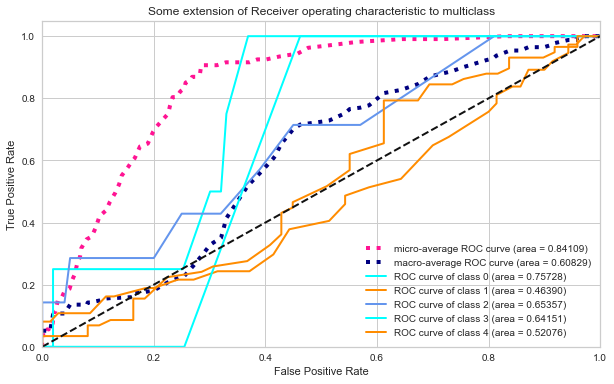

In [85]:
# rf on d2v
model = rf_model_d2v
xt = X_test_d2v
yt = y_test
plot_roc_for_multiclass_classification(model,xt,yt) # classes=['cafe','groceries', 'restaurant', 'salary','transfer']

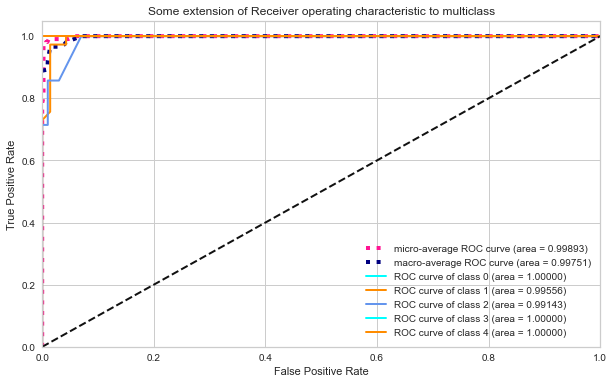

In [86]:
# rf on tfidf
model = rf_model_tfidf
xt = X_test_tfidf
yt = ytest
plot_roc_for_multiclass_classification(model,xt,yt) # classes=['cafe','groceries', 'restaurant', 'salary','transfer']

Big difference between the 2 models, on all metrics.

## Test on unknown transactions

Retrieve unknown dataset
- `myLabel` = None

In [87]:
# retrieve unknown dataset
df_unknown = df_.loc[df_['myLabel'].isna(), ['TransactionDescription','clean_text', 'myLabel']].reset_index(drop=True)
df_unknown.head()

,TransactionDescription,clean_text,myLabel
0,visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322,visa purchase dbs linden park primar linden park Thursday September 30,None
1,"intl atmpurchase - receipt 164433 bigscoots, inc www.bigscoot foreign currency amount usd 34.95 ...",intl atmpurchase bigscoots inc foreign currency amount usd Wednesday September 29,None
2,direct debit - receipt 152678 073053 ngtcraigm 75098090 to 838321094 014002,direct debit ngtcraigm to Friday October 1,None
3,eftpos purchase - receipt 004869 teamazing bubble te rwood date 04/10/21 card 8322,eftpos purchase teamazing bubble te rwood Saturday April 10,None
4,visa purchase - receipt 185431 jbm amusements evanston par date 03/10/21 card 8322,visa purchase jbm amusements evanston par Wednesday March 10,None


In [88]:
# predict with doc2vec vectorization
new_ = ['visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322']
new_ = util_initialclean(new_[0])
clean = util_preprocess_to_list(new_, stem=False)
tagged = [gensim.models.doc2vec.TaggedDocument(clean, 0)]
vector = [d2v_model.infer_vector(tagged[0].words)]
pred = rf_model_d2v.predict(vector)
print(pred)

['transfer']


In [89]:
# predict with doc2vec vectorization
new_ = ['direct debit - receipt 152678 073053 ngtcraigm 75098090 to 838321094 014002']
new_ = util_initialclean(new_[0])
clean = util_preprocess_to_list(new_, stem=False)
tagged = [gensim.models.doc2vec.TaggedDocument(clean, 0)]
vector = [d2v_model.infer_vector(tagged[0].words)]
pred = rf_model_d2v.predict(vector)
print(pred)

['groceries']


In [90]:
# predict with doc2vec vectorization
new_ = ['visa purchase - receipt 185431 jbm amusements evanston par date 03/10/21 card 8322']
new_ = util_initialclean(new_[0])
clean = util_preprocess_to_list(new_, stem=False)
tagged = [gensim.models.doc2vec.TaggedDocument(clean, 0)]
vector = [d2v_model.infer_vector(tagged[0].words)]
pred = rf_model_d2v.predict(vector)
print(pred)

['groceries']


In [91]:
# predict with doc2vec vectorization
new_ = df_unknown['TransactionDescription'][1]
new_ = util_initialclean(new_[0])
clean = util_preprocess_to_list(new_, stem=False)
tagged = [gensim.models.doc2vec.TaggedDocument(clean, 0)]
vector = [d2v_model.infer_vector(tagged[0].words)]
pred = rf_model_d2v.predict(vector)
print(pred)

['groceries']


In [92]:
# predict with TF-IDF vectorization
new_ = ['visa purchase - receipt 164431 dbs*linden park primar linden park date 30/09/21 card 8322']
vector = tfidf_ml.transform(new_)
pred = rf_model_tfidf.predict(vector)
print(pred)

['groceries']


In [93]:
new_ = ['direct debit - receipt 152678 073053 ngtcraigm 75098090 to 838321094 014002']
vector = tfidf_ml.transform(new_)
pred = rf_model_tfidf.predict(vector)
print(pred)

['transfer']


In [94]:
new_ = ['visa purchase - receipt 185431 jbm amusements evanston par date 03/10/21 card 8322']
vector = tfidf_ml.transform(new_)
pred = rf_model_tfidf.predict(vector)
print(pred)

['groceries']


In [95]:
new_ = [df_unknown['TransactionDescription'][1]]
vector = tfidf_ml.transform(new_)
pred = rf_model_tfidf.predict(vector)
print(pred)

['transfer']


In [96]:
df_unknown['TransactionDescription'][1]

'intl atmpurchase - receipt 164433 bigscoots, inc www.bigscoot foreign currency amount usd 34.95 date 29/09/21 card 3689'

RF model or other ML algorithms return final classifrication decision by using sigmoid function to compress prediction to a probability. There are other ML options such as probability-based Naive Bayes to directly compute probability between feature and label. Next, instead of trying these methods, we try to solve the problem from another perspecitve using RNN and Attention mechinism. 

# RNN model on sequences

Continue semi-supervised approach, move on to RNN model, BiLSTM

In [97]:
# define a callback parameter
threshold = 0.75
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_cohen_kappa') > threshold):
            print("\nReached %2.2f%% kappa, so stopping training!!" %(threshold*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

Prep data

In [98]:
# prep data
df_rnn = df_.loc[df_['myLabel'].notna(), ['clean_text','TransactionAmount', 'myLabel']].reset_index(drop=True)
df_rnn['clean_text'] = df_rnn['clean_text'].apply(lambda x: util_preprocess_to_sentence(x
                                                          , rm_stopwords=True
                                                           , stem=False
                                                           , lemm=False))

In [99]:
vocab_size = 400
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')
tokenizer.fit_on_texts(df_rnn['clean_text'])

In [100]:
print('Unique tokens: {}'.format(len(tokenizer.index_word)))
print(tokenizer.word_index)

Unique tokens: 363
{'<UNK>': 1, 'purchase': 2, 'visa': 3, 'transfer': 4, 'monday': 5, 'thursday': 6, 'osko': 7, 'december': 8, 'internal': 9, 'november': 10, 'savings': 11, 'maximiser': 12, 'february': 13, 'from': 14, 'january': 15, 'glenside': 16, 'to': 17, 'march': 18, 'saturday': 19, 'wednesday': 20, 'october': 21, 'tuesday': 22, 'friday': 23, 'coles': 24, 'deposit': 25, 'sunday': 26, 'frewville': 27, 'payment': 28, 'kye': 29, 'oon': 30, 'eftpos': 31, 'cheong': 32, 'kilburn': 33, 'fee': 34, 'atm': 35, '3': 36, '10': 37, '11': 38, 'mrs': 39, 'costco': 40, '17': 41, 'adelaide': 42, '1': 43, '12': 44, '22': 45, '13': 46, '2': 47, '16': 48, '21': 49, '29': 50, 'wholesale': 51, 'minseok': 52, 'otr': 53, '24': 54, 'bunnings': 55, 'mart': 56, 'aus': 57, 'intl': 58, 'transaction': 59, 'cash': 60, 'mr': 61, 'rebate': 62, '7': 63, '14': 64, '27': 65, 'song': 66, 'foodland': 67, 'park': 68, '23': 69, '25': 70, '15': 71, 'firle': 72, '31': 73, 'pty': 74, 'ltd': 75, '26': 76, 'sushi': 77, 'septe

(531, 13)


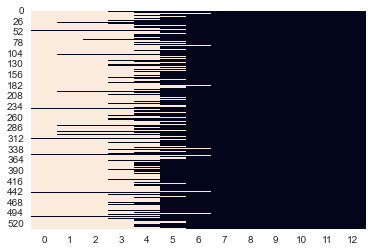

vocab_size: 400
maxlen: 13
Embedding dim: 5

x_train shape: (371, 13)	y_train shape: (371, 5)
x_test shape: (160, 13)	y_test shape: (160, 5)



In [101]:
# Set parameters
maxlen = 13
embed_dim = 5 # 400**0.25
num_class = df_rnn['myLabel'].nunique()

# fix X
X_seq = tokenizer.texts_to_sequences(df_rnn['clean_text'].values)
X = pad_sequences(X_seq, maxlen)
print(X.shape)

# plot sequence plus padded sequence
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

# fix Y
Y = pd.get_dummies(df_rnn['myLabel']).values
print('vocab_size: {}\nmaxlen: {}\nEmbedding dim: {}\n'.format(vocab_size, maxlen, embed_dim))

# split
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size = 0.3, random_state=420)
print('x_train shape: {}\ty_train shape: {}\nx_test shape: {}\ty_test shape: {}\n'.format(
    x_train_rnn.shape, y_train_rnn.shape, x_test_rnn.shape, y_test_rnn.shape))


Illustrated padded sequences of each document, that eventually have same length of maxlen=13

In [102]:
# example of one document
print(df_rnn['clean_text'][1])
print(X_seq[1])
print(X[1])

visa purchase viet hoa restaurant woodville ga Wednesday September 29
[3, 2, 203, 204, 205, 206, 207, 20, 78, 50]
[  0   0   0   3   2 203 204 205 206 207  20  78  50]


## BiLSTM model

![bilstm](https://github.com/ericwanga/categorise-bank-transaction/blob/main/img/BiLSTM.jpg?raw=true)

In [103]:
#embed_dim = 5 # shape(x) = 4 # the embedding space width

bilstm = Sequential()
bilstm.add(Embedding(vocab_size+1, output_dim=embed_dim, input_length=maxlen))
bilstm.add(Bidirectional(LSTM(64)))
bilstm.add(Dense(64, activation='relu')) # flatten to embed_dim * maxlen (padded length) = 4* 15 = 60
bilstm.add(Dense(num_class, activation='softmax'))

# compile
bilstm.compile(optimizer='adam' # Adam(learning_rate=0.0005) 
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy', tfa.metrics.F1Score(num_classes=num_class, average='weighted')
                             , tfa.metrics.CohenKappa(num_classes=num_class)])
print(vocab_size, embed_dim, maxlen)
print(bilstm.summary())

# train
num_epoch = 15
threshold = 0.8 # kappa threshold
time0=time()
history_bilstm = bilstm.fit(x_train_rnn, y_train_rnn, epochs=num_epoch
                      # , validation_steps=15
                       , validation_data=(x_test_rnn, y_test_rnn)
                            , callbacks=[callbacks]
                       )
timediff = time()-time0
print(timediff)

400 5 13
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 5)             2005      
                                                                 
 bidirectional (Bidirectiona  (None, 128)              35840     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 46,426
Trainable params: 46,426
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
12/12 [==============================] - 6s 149ms/step - loss: 1.5669 - accuracy: 0.4609 - f1

## Metrics

5/5 [==============================] - 0s 4ms/step - loss: 0.2567 - accuracy: 0.8875 - f1_score: 0.8699 - cohen_kappa: 0.8089


(0.0, 1.6355395197868348)

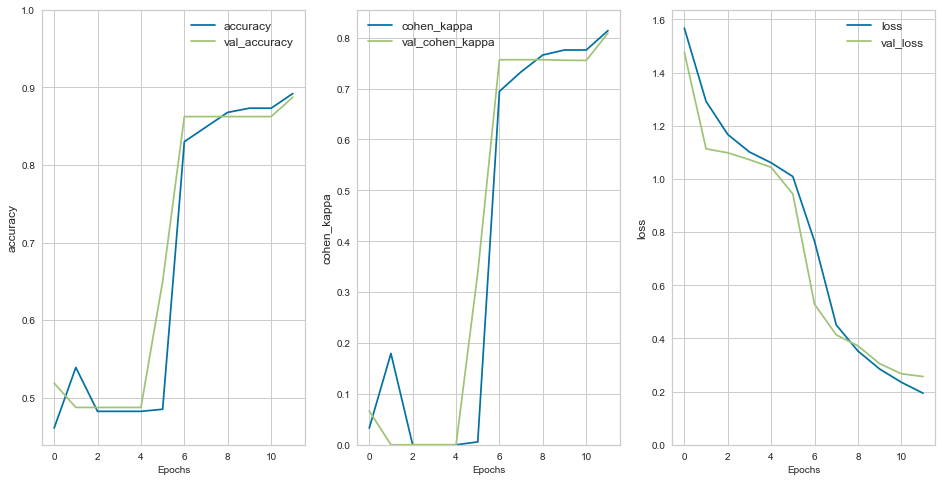

In [104]:
test_metrics_bilstm = bilstm.evaluate(x_test_rnn, y_test_rnn)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plot_learning_graphs(history_bilstm, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 3, 2)
plot_learning_graphs(history_bilstm, 'cohen_kappa')
plt.ylim(0, None)
plt.subplot(1, 3, 3)
plot_learning_graphs(history_bilstm, 'loss')
plt.ylim(0, None)

Store result

In [105]:
Model='bilstm_embeddings'
results={'Accuracy':test_metrics_bilstm[1], 'F1':test_metrics_bilstm[2]
         , 'Loss':test_metrics_bilstm[0], 'Kappa':test_metrics_bilstm[3]}
storage.update({Model: {'results': results}})

In [106]:
list(storage.items())

[('rf_d2v',
  {'results': {'Accuracy': 0.4953271028037383,
    'Precision': 0.4953271028037383,
    'Recall': 0.4953271028037383,
    'Kappa': 0.04306061609804568}}),
 ('rf_tfidf',
  {'results': {'Accuracy': 0.9719626168224299,
    'Precision': 0.9719626168224299,
    'Recall': 0.9719626168224299,
    'Kappa': 0.9515105740181269}}),
 ('bilstm_embeddings',
  {'results': {'Accuracy': 0.887499988079071,
    'F1': 0.869949460029602,
    'Loss': 0.25669389963150024,
    'Kappa': 0.8088791370391846}})]

In [107]:
classes_rnn = ['cafe','groceries', 'restaurant', 'salary','transfer']
labels_rnn = np.argmax(y_test_rnn, axis=1)
pred_bilstm = bilstm.predict(x_test_rnn)
label_pred_bilstm = np.argmax(pred_bilstm, axis=1)

cm_bilstm = confusion_matrix(y_true=labels_rnn, y_pred=label_pred_bilstm, labels=[0,1,2,3,4])
report_bilstm = classification_report(labels_rnn, label_pred_bilstm, labels=[0,1,2,3,4])

print('Confusion Matrix:\n', cm_bilstm, '\nClassification rreport:\n', report_bilstm)

Confusion Matrix:
 [[ 0  3  3  0  0]
 [ 1 61  0  0  0]
 [ 2  5  4  0  0]
 [ 2  0  0  0  1]
 [ 0  1  0  0 77]] 
Classification rreport:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.87      0.98      0.92        62
           2       0.57      0.36      0.44        11
           3       0.00      0.00      0.00         3
           4       0.99      0.99      0.99        78

    accuracy                           0.89       160
   macro avg       0.49      0.47      0.47       160
weighted avg       0.86      0.89      0.87       160



C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.7178053201257238


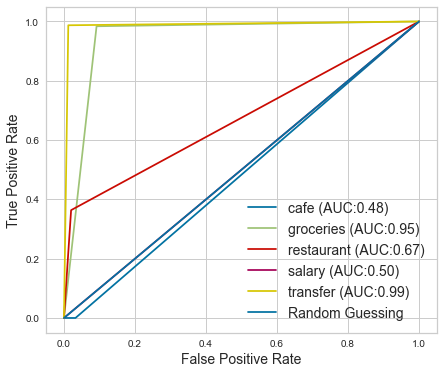

In [108]:
# plot AUC
fig, c_ax = plt.subplots(1,1,figsize = (7, 6))
targetlabel = ['cafe', 'groceries','restaurant', 'salary','transfer']
auc_bilstm = multiclass_roc_auc_score(labels_rnn, label_pred_bilstm, targetlabel)

# plot
print('ROC AUC score:', auc_bilstm)
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.show()

In [109]:
print('classes in testset: {}'.format(np.unique(labels_rnn)))
print('classes predicted: {}'.format(np.unique(label_pred_bilstm)))

classes in testset: [0 1 2 3 4]
classes predicted: [0 1 2 4]


As we are using labelled data from Known Matching step to train the model for all 5 classes, considering the small amount of Salary transactions, we splitted the train/test sets on a 0.7:0.3 ratio to guarantee some samples in both sets. This could affect the chance that model learning this particular class. 

This BiLSTM model *Salary* were not learned. *Cafe* class was incorrectly learned. Model has a weak prediction power on *Restaurant* class.  Other 2 classes were well learned. Recall of *Transfer* was satisfactory.

In [110]:
# save result
json.dump(storage, open('result/storage.json', 'w'))

In [111]:
# save model
# save whole model (config + weights)
bilstm.save('model/bilstm')
# save weight-only
bilstm.save('model/bilstm.h5')

INFO:tensorflow:Assets written to: model/bilstm\assets


INFO:tensorflow:Assets written to: model/bilstm\assets


# Encoder model on sequences

Transformer (Vaswani et al. 2017) Encoder to process input word embeddings in parallel

![transformer_encoder](https://github.com/ericwanga/categorise-bank-transaction/blob/main/img/TEncoder.jpg?raw=true)

> Vaswani, A, Shazeer, N, Parmar, N, Uszkoreit, J, Jones, L, Gomez, AN, . . . 		Polosukhin, I 2017, 'Attention is all you need', Advances in neural information 	processing systems, vol. 30.

In [112]:
# prep data
df_TEncoder = df_.loc[df_['myLabel'].notna(), ['clean_text','TransactionAmount', 'myLabel']].reset_index(drop=True)
df_TEncoder['clean_text'] = df_TEncoder['clean_text'].apply(lambda x: util_preprocess_to_sentence(x
                                                          , rm_stopwords=True
                                                           , stem=False
                                                           , lemm=False))

# fit tokenizer with new dataframe
tokenizer.fit_on_texts(df_TEncoder['clean_text'])

(531, 15)


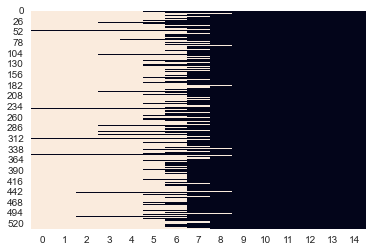

vocab_size: 400
maxlen: 15
Embedding dim: 6

x_train shape: (424, 15)	y_train shape: (424, 5)
x_test shape: (107, 15)	y_test shape: (107, 5)



In [114]:
# Set parameters
maxlen = 15
embed_dim = 6 # Embedding size for each token 400**0.27 
num_class = df_TEncoder['myLabel'].nunique()

# fix X
X_seq = tokenizer.texts_to_sequences(df_TEncoder['clean_text'].values)
X = pad_sequences(X_seq, maxlen)
print(X.shape)

# plot sequence plus padded sequence
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

# fix Y
Y = pd.get_dummies(df_TEncoder['myLabel']).values
print('vocab_size: {}\nmaxlen: {}\nEmbedding dim: {}\n'.format(vocab_size, maxlen, embed_dim))

# split
x_train_TEncoder, x_test_TEncoder, y_train_TEncoder, y_test_TEncoder = train_test_split(X, Y, test_size = 0.2, random_state=420)
print('x_train shape: {}\ty_train shape: {}\nx_test shape: {}\ty_test shape: {}\n'.format(
    x_train_TEncoder.shape, y_train_TEncoder.shape, x_test_TEncoder.shape, y_test_TEncoder.shape))

For this model we pad sequences to length of 15. Embedding dimension of 6 can be retrieved from Rule of Thum embedding_dimension = num_of_categories \*\* 0.25 (~0.27). We split on 0.8:0.2 ratio to give slightly more chance for model to learn the minority class especialy *salary*. 

## Encoder model

In [115]:
num_heads = 2  # Number of attention heads
ff_dim = 128 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size+1, embed_dim) # embedding + positioning
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x) # block1
x = transformer_block(x) # block2
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(80, activation="relu")(x) # flatten to maxlen * embed_dim size of elements, eg. 15*6=90 in this case
outputs = layers.Dense(num_class, activation="softmax")(x)

TEncoder = keras.Model(inputs=inputs, outputs=outputs)

# compile 
TEncoder.compile(optimizer='adam' # Adam(learning_rate =0.0009) # , decay=0.00001
                     , loss="categorical_crossentropy"
                     , metrics=['accuracy'
                             , tfa.metrics.F1Score(num_classes=num_class, average='weighted')
                             , tfa.metrics.CohenKappa(num_classes=num_class)
                            #   , METRICS
                               ])
print(vocab_size+1, embed_dim, maxlen)
print(TEncoder.summary())

# train
threshold = 0.8 # kappa threshold
num_epoch = 10
time0=time()
history_TEncoder = TEncoder.fit(x_train_TEncoder, y_train_TEncoder, epochs=num_epoch,
                  #  validation_steps=15,
                    validation_data=(x_test_TEncoder, y_test_TEncoder), callbacks=[callbacks])
timediff = time()-time0
print('\n',timediff)

401 6 15
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 token_and_position_embedding (  (None, 15, 6)       2496        ['input_1[0][0]']                
 TokenAndPositionEmbedding)                                                                       
                                                                                                  
 transformer_block (Transformer  (None, 15, 6)       2024        ['token_and_position_embedding[0]
 Block)                                                          [0]',                            
                                                                  'transformer_block[

## Metrics

4/4 [==============================] - 0s 4ms/step - loss: 0.2576 - accuracy: 0.9065 - f1_score: 0.8813 - cohen_kappa: 0.8312


(0.0, 1.655877098441124)

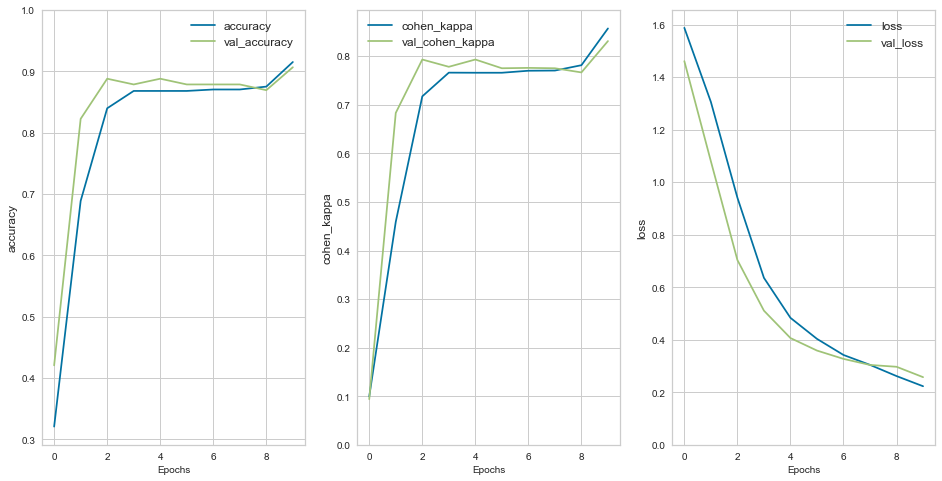

In [116]:
# evaluate
test_metrics_TEncoder = TEncoder.evaluate(x_test_TEncoder, y_test_TEncoder)

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plot_learning_graphs(history_TEncoder, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 3, 2)
plot_learning_graphs(history_TEncoder, 'cohen_kappa')
plt.ylim(0, None)
plt.subplot(1, 3, 3)
plot_learning_graphs(history_TEncoder, 'loss')
plt.ylim(0, None)

In [117]:
# store result
Model='TEncoder'
results_TEncoder={'Accuracy':test_metrics_TEncoder[1], 'F1':test_metrics_TEncoder[2]
         , 'Loss':test_metrics_TEncoder[0], 'Kappa':test_metrics_TEncoder[3]}
storage.update({Model: {'results': results_TEncoder}})

In [118]:
list(storage.items())

[('rf_d2v',
  {'results': {'Accuracy': 0.4953271028037383,
    'Precision': 0.4953271028037383,
    'Recall': 0.4953271028037383,
    'Kappa': 0.04306061609804568}}),
 ('rf_tfidf',
  {'results': {'Accuracy': 0.9719626168224299,
    'Precision': 0.9719626168224299,
    'Recall': 0.9719626168224299,
    'Kappa': 0.9515105740181269}}),
 ('bilstm_embeddings',
  {'results': {'Accuracy': 0.887499988079071,
    'F1': 0.869949460029602,
    'Loss': 0.25669389963150024,
    'Kappa': 0.8088791370391846}}),
 ('TEncoder',
  {'results': {'Accuracy': 0.9065420627593994,
    'F1': 0.8812620639801025,
    'Loss': 0.25756531953811646,
    'Kappa': 0.8311770558357239}})]

In [119]:
classes_TEncoder = ['cafe','groceries', 'restaurant', 'salary','transfer']
labels_TEncoder = np.argmax(y_test_TEncoder, axis=1)
pred_TEncoder = TEncoder.predict(x_test_TEncoder)
label_pred_TEncoder = np.argmax(pred_TEncoder, axis=1)

cm_TEncoder = confusion_matrix(y_true=labels_TEncoder, y_pred=label_pred_TEncoder, labels=[0,1,2,3,4])
report_TEncoder = classification_report(labels_TEncoder, label_pred_TEncoder, labels=[0,1,2,3,4])

print('Confusion Matrix:\n', cm_TEncoder, '\nClassification rreport:\n', report_TEncoder)

Confusion Matrix:
 [[ 2  2  0  0  0]
 [ 0 36  0  0  1]
 [ 1  4  1  0  1]
 [ 0  0  0  0  1]
 [ 0  0  0  0 58]] 
Classification rreport:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.86      0.97      0.91        37
           2       1.00      0.14      0.25         7
           3       0.00      0.00      0.00         1
           4       0.95      1.00      0.97        58

    accuracy                           0.91       107
   macro avg       0.69      0.52      0.54       107
weighted avg       0.90      0.91      0.88       107



C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\erwang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC score: 0.7459182602455835


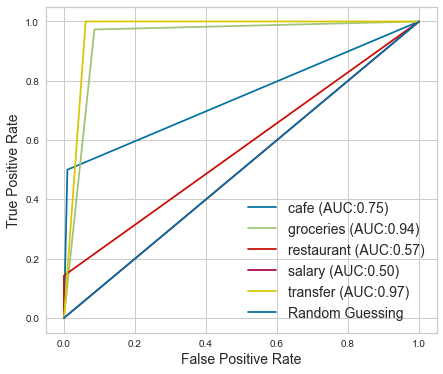

In [120]:
# plot AUC
fig, c_ax = plt.subplots(1,1,figsize = (7, 6))
targetlabel = ['cafe', 'groceries','restaurant', 'salary','transfer']
auc_TEncoder = multiclass_roc_auc_score(labels_TEncoder, label_pred_TEncoder, targetlabel)


print('ROC AUC score:', auc_TEncoder)
c_ax.legend(fontsize=14)
c_ax.set_xlabel('False Positive Rate', fontsize=14)
c_ax.set_ylabel('True Positive Rate', fontsize=14)
plt.show()

We see improvement of predciton performance on class *cafe* from 0.49 to 0.75. *Salary* class remains unlearned. Other 2 classes were well learned. Recall of class *transfer* was satisfactory.

In [121]:
# save result
json.dump(storage, open('result/storage.json', 'w'))

In [122]:
# save model
# save whole model (config + weights)
TEncoder.save('model/TEncoder')

INFO:tensorflow:Assets written to: model/TEncoder\assets


INFO:tensorflow:Assets written to: model/TEncoder\assets


# Models summary

In [123]:
summary = pd.DataFrame.from_dict(storage.items())
summary.columns = ['model', 'results']
summary

,model,results
0,rf_d2v,"{'results': {'Accuracy': 0.4953271028037383, 'Precision': 0.4953271028037383, 'Recall': 0.495327..."
1,rf_tfidf,"{'results': {'Accuracy': 0.9719626168224299, 'Precision': 0.9719626168224299, 'Recall': 0.971962..."
2,bilstm_embeddings,"{'results': {'Accuracy': 0.887499988079071, 'F1': 0.869949460029602, 'Loss': 0.25669389963150024..."
3,TEncoder,"{'results': {'Accuracy': 0.9065420627593994, 'F1': 0.8812620639801025, 'Loss': 0.257565319538116..."


In [127]:
acc_bilstm = summary.loc[0,'results']['results']['Accuracy']
acc_rf_dev = summary.loc[1,'results']['results']['Accuracy']
acc_rf_tfidf = summary.loc[2,'results']['results']['Accuracy']
acc_TEncoder = summary.loc[3,'results']['results']['Accuracy']
summary['accuracy'] = [acc_bilstm,acc_rf_dev,acc_rf_tfidf,acc_TEncoder]

kappa_bilstm = summary.loc[0,'results']['results']['Kappa']
kappa_rf_dev = summary.loc[1,'results']['results']['Kappa']
kappa_rf_tfidf = summary.loc[2,'results']['results']['Kappa']
kappa_TEncoder = summary.loc[3,'results']['results']['Kappa']
summary['kappa'] = [kappa_bilstm,kappa_rf_dev,kappa_rf_tfidf,kappa_TEncoder]

summary['AUC_weighted'] = [0.60829, 0.99751, auc_bilstm, auc_TEncoder]

summary

,model,results,accuracy,kappa,AUC_weighted
0,rf_d2v,"{'results': {'Accuracy': 0.4953271028037383, 'Precision': 0.4953271028037383, 'Recall': 0.495327...",0.495327,0.043061,0.608290
1,rf_tfidf,"{'results': {'Accuracy': 0.9719626168224299, 'Precision': 0.9719626168224299, 'Recall': 0.971962...",0.971963,0.951511,0.997510
2,bilstm_embeddings,"{'results': {'Accuracy': 0.887499988079071, 'F1': 0.869949460029602, 'Loss': 0.25669389963150024...",0.887500,0.808879,0.717805
3,TEncoder,"{'results': {'Accuracy': 0.9065420627593994, 'F1': 0.8812620639801025, 'Loss': 0.257565319538116...",0.906542,0.831177,0.745918


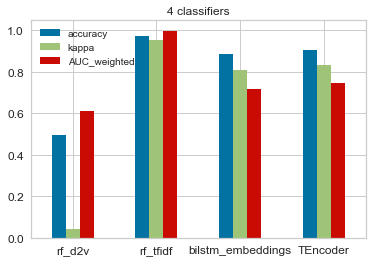

In [128]:
ax = summary[['accuracy','kappa','AUC_weighted']].plot(kind='bar', title='4 classifiers', fontsize=12)
ax.set_xticklabels(summary.model, rotation=0)
plt.show()

In terms of semi-supervised approach of levearging a classifier built on known labelled data to predict new data, our experiments of Random Forest model trained from TF-IDF matrix achieved best performance 0.97/0.95 (accuracy/cohen kappa) overall as well as across each of the 5 classes. Followed by Transformer Encoder model of 0.9/0.83. Followed by BiLSTM model with similar performance. 

RF model trained on document level vectors did not work well, especially the level of classification agreement across different classes is really low, denoted by kappa score. The overall weighted AUC score was supported by 2 out of 5 classes but it does not mean minority classes can be well looked after. If want to tune the model, vocabulary size of the doc2vec model can be tried, and hyperparameters of RF model can be tuned, acoompanied by learning curves or cross-validation during the tuning. 

Also noticed the training time cost differences between RNN BiLSTM model and Encoder model, a decrease from 7.9s down to 4.7s, thanks to the the attendion mechanism that takes the entire document as input and compute in parallel, rather than computing word by word sequentially like RNN BiLSTM operates.

# Vector Similarity

This vector similarity-based unsupervised document (Schopf et al., 2021) classification method was proposed in 2021. Sequence of working: prepare 2 vectors to get Label vector, then for new test document, convert to document vector and calculate distance with this label vector, then put to similar Label as output.

There is another similar study in this approach that mentioned enrichment (Haj-Yahia et al., 2019) along the way to get Label vector.

I attemp to implement the first approach and add the enrichment step from the 2nd paper into it, just to see if this approach works and in what way the enrichment step helps improving the output performance.

Keyword vector, doc vector and Label vector in the same shared vector space. Then compare the similarity between unknown document's vector with the learned label vectors.

![shared_vector_space](https://github.com/ericwanga/categorise-bank-transaction/blob/main/img/vectorspace.jpg?raw=true)

> Schopf, T., Braun, D., & Matthes, F. (2021). Lbl2Vec: An Embedding-based Approach for Unsupervised Document Retrieval on Predefined Topics. WEBIST,  https://www.scitepress.org/Link.aspx?doi=10.5220/0010710300003058 

> Haj-Yahia, Z., Sieg, A., & Deleris, L. A. (2019). Towards unsupervised text classification leveraging experts and word embeddings. Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics, https://aclanthology.org/P19-1036.pdf 
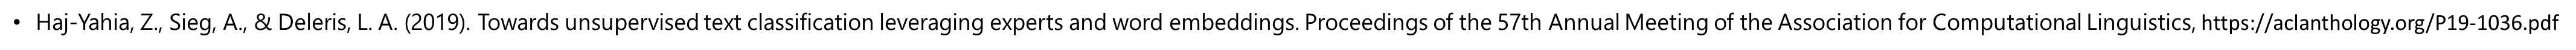

## Without enrichment

In [126]:
# prep data
df_vecsim = df_[df_['myLabel'] != 'salary'] # 4-class
#df_vecsim = df_[df_['Label'].isna()] # 4-class
df_vecsim = df_vecsim.reset_index(drop=True)
print(df_vecsim.shape)

keyword_labels = pd.DataFrame(np.random.randn(4,4)
                             , columns=['class_index','class_name','keywords','num_keywords'])
class_index = [0,1,2,3]
class_name = ['restaurant','cafe','groceries','transfer']
keywords = [['restaurant','kfc','mcdonalds','sushi']
            ,['cafe','coffee','baker','bakery','deli']
            ,['grocer','grocery','groceries'
              #,'costco','coles','woolworths','foodland','bunnings','kmart'
             ]
            ,['transfer','deposit','withdraw','credit','savings','fee']
           ]
num_keywords = [len(l) for l in keywords]
keyword_labels['class_index'] = class_index
keyword_labels['class_name'] = class_name
keyword_labels['keywords']= keywords
keyword_labels['num_keywords'] = num_keywords
keyword_labels

(886, 5)


,class_index,class_name,keywords,num_keywords
0,0,restaurant,"[restaurant, kfc, mcdonalds, sushi]",4
1,1,cafe,"[cafe, coffee, baker, bakery, deli]",5
2,2,groceries,"[grocer, grocery, groceries]",3
3,3,transfer,"[transfer, deposit, withdraw, credit, savings, fee]",6


## With enrichment

In [129]:
# load and instantiate pretrained glove embedding 300d
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [151]:
# save as
df_vecsim = df_[df_['myLabel'] != 'salary'] # 4-class
#df_vecsim = df_[df_['Label'].isna()] # 4-class
df_vecsim = df_vecsim.reset_index(drop=True)
print(df_vecsim.shape)
df_vecsim.tail()

## Create Dictionary {category:[keywords]}
dic_clusters = {}

# restaurant 13
dic_clusters["Restaurant"] = get_similar_words(['restaurant','kfc','mcdonalds','sushi'], top=10, nlp=nlp)
item = ['cafe','starbucks','grocery']
remove_values_from_list(dic_clusters["Restaurant"], item)

# cafe 12
dic_clusters["Cafe"] = get_similar_words(['cafe','coffee','baker','bakery','bakers'], top=10, nlp=nlp)
item = ['restaurant','restaurants','grocery','supermarket']
remove_values_from_list(dic_clusters["Cafe"], item)

# groceries 16
dic_clusters["Groceries"] = get_similar_words(['supermarket','market','mart','grocer','grocery','coles','woolworths'
                                               ,'foodland','bunnings','pharmacy','costco','kmart'], top=5, nlp=nlp)
item = ['stores','shops']
remove_values_from_list(dic_clusters['Groceries'], item)

# transfer 14
dic_clusters['Transfer'] = get_similar_words(['deposit','withdrawal','credit','savings','bill','transfer','fee'], top=8, nlp=nlp)
item = ['loan']
remove_values_from_list(dic_clusters['Transfer'], item)

keyword_labels = pd.DataFrame(np.random.randn(4,4), columns=['class_index','class_name','keywords','num_keywords'])
class_index = [0,1,2,3]
class_name = ['restaurant','cafe','groceries','transfer']
keywords = []
for k,v in dic_clusters.items():
    keywords.append(dic_clusters[k])
    print('{}: {}'.format(k,v))

num_keywords = [len(l) for l in keywords]
keyword_labels['class_index'] = class_index
keyword_labels['class_name'] = class_name
keyword_labels['keywords']= keywords
keyword_labels['num_keywords'] = num_keywords
#keyword_labels['class_index'] = keyword_labels.index
keyword_labels

(886, 5)
Restaurant: ['sushi', 'taco', 'burger', 'mcdonalds', 'eatery', 'eateries', 'diners', 'kfc', 'restaurant', 'restaurants', 'mcdonald', 'pizza', 'fast-food']
Cafe: ['gourmet', 'shop', 'bakery', 'bread', 'baker', 'café', 'cafe', 'store', 'shops', 'deli', 'coffee', 'bakers']
Groceries: ['costco', 'woolworths', 'mart', 'grocery', 'coles', 'foodland', 'store', 'wal', 'pharmacy', 'kmart', 'supermarket', 'retailer', 'market', 'bunnings', 'grocer', 'supermarkets']
Transfer: ['credit', 'pay', 'payments', 'guarantee', 'tax', 'money', 'fee', 'withdrawal', 'payment', 'bill', 'fees', 'transfer', 'savings', 'deposit']


,class_index,class_name,keywords,num_keywords
0,0,restaurant,"[sushi, taco, burger, mcdonalds, eatery, eateries, diners, kfc, restaurant, restaurants, mcdonal...",13
1,1,cafe,"[gourmet, shop, bakery, bread, baker, café, cafe, store, shops, deli, coffee, bakers]",12
2,2,groceries,"[costco, woolworths, mart, grocery, coles, foodland, store, wal, pharmacy, kmart, supermarket, r...",16
3,3,transfer,"[credit, pay, payments, guarantee, tax, money, fee, withdrawal, payment, bill, fees, transfer, s...",14


## Lbl2vec model

Filter dataset to only documents that belong to classes where we defined our keywords

In [152]:
# # map self-defined labels to doc
# df_vecsim['class_index'] = 999
# idx = 0
# for lst in keyword_label['keywords']:
#     df_vecsim.loc[df_vecsim['clean_text'].str.contains('|'.join(lst)), 'class_index'] = idx
#     idx += 1    

# df_vecsim.head()
print('input dataset shape: {}'.format(df_vecsim.shape))
df_vecsim = df_vecsim[df_vecsim['myLabel'].isin(list(keyword_labels['class_name']))]
df_vecsim = df_vecsim.reset_index(drop=True)
# mapping = dict(keyword_labels[['class_name','class_index']].values)
# df_vecsim['class_index'] = df_vecsim['myLabel'].map(mapping)
# df_vecsim = df_vecsim.reset_index(drop=True)
# #df_vecsim.head()

# Split to train and test sets
print('after matching with defined keywords: {}'.format(df_vecsim.shape))
train_size = round(df_vecsim.shape[0] * 0.9)
df_vecsim['data_set_type'] = 'train'
df_vecsim.loc[train_size:, 'data_set_type'] = 'test'

print('Train size: {}'.format(train_size))

# # extract the records that we are sure about their labels
# df_vecsim = df_vecsim[df_vecsim['class_index'].isin(keyword_label['class_index'])]
# df_vecsim = df_vecsim.reset_index(drop=True)
# df_vecsim.shape

# tokenize and tag records' descriptions
df_vecsim['tagged_docs'] = df_vecsim.apply(lambda row: doc2vec.TaggedDocument(tokenize(row['clean_text']), [str(row.name)]), axis=1)

# add doc key column
df_vecsim['doc_key'] = df_vecsim.index.astype(str)

# add class name column
df_vecsim = df_vecsim.merge(keyword_labels, left_on='myLabel', right_on='class_name',how='left')

print(df_vecsim.shape)
print(df_vecsim.data_set_type.value_counts())
df_vecsim.head()

(886, 5)
(524, 5)
Train size: 472
(524, 12)
train    472
test      52
Name: data_set_type, dtype: int64


,AccountId,TransactionDescription,TransactionAmount,myLabel,clean_text,data_set_type,tagged_docs,doc_key,class_index,class_name,keywords,num_keywords
0,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164427 sfs nrah sushi sushi adelaide date 29/09/21 card 8322,-6.50,restaurant,visa purchase sfs nrah sushi sushi adelaide Wednesday September 29,train,"([visa, purchase, sfs, nrah, sushi, sushi, adelaide, wednesday, september], [0])",0,0,restaurant,"[sushi, taco, burger, mcdonalds, eatery, eateries, diners, kfc, restaurant, restaurants, mcdonal...",13
1,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164428 viet hoa restaurant woodville ga date 29/09/21 card 3689,-46.00,restaurant,visa purchase viet hoa restaurant woodville ga Wednesday September 29,train,"([visa, purchase, viet, hoa, restaurant, woodville, ga, wednesday, september], [1])",1,0,restaurant,"[sushi, taco, burger, mcdonalds, eatery, eateries, diners, kfc, restaurant, restaurants, mcdonal...",13
2,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164429 costco wholesale aus kilburn date 29/09/21 card 3689,-875.88,groceries,visa purchase costco wholesale aus kilburn Wednesday September 29,train,"([visa, purchase, costco, wholesale, aus, kilburn, wednesday, september], [2])",2,2,groceries,"[costco, woolworths, mart, grocery, coles, foodland, store, wal, pharmacy, kmart, supermarket, r...",16
3,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164430 frewville cafe baker frewville date 29/09/21 card 3689,-16.00,cafe,visa purchase frewville cafe baker frewville Wednesday September 29,train,"([visa, purchase, frewville, cafe, baker, frewville, wednesday, september], [3])",3,1,cafe,"[gourmet, shop, bakery, bread, baker, café, cafe, store, shops, deli, coffee, bakers]",12
4,773edf8c-e78f-11ec-bd51-1a25830e1bc2,visa purchase - receipt 164432 target 5024 newton date 30/09/21 card 8322,-5.00,groceries,visa purchase target newton Thursday September 30,train,"([visa, purchase, target, newton, thursday, september], [4])",4,2,groceries,"[costco, woolworths, mart, grocery, coles, foodland, store, wal, pharmacy, kmart, supermarket, r...",16


In [141]:
# in order to get optimal Lbl2Vec results the given Doc2Vec model 
# should be trained with the parameters “dbow_words=1” and “dm=0”
# but if training the model from scratch, can comment out the parameter "doc2vec_model" 
# that points to this pretrained model when init model
doc2vec_model = doc2vec.Doc2Vec(documents=df_vecsim['tagged_docs'][df_vecsim['data_set_type']=='train']
                                , dbow_words=1
                                , dm=1)

# init model with parameters
Lbl2Vec_model = Lbl2Vec(keywords_list=list(keyword_labels.keywords)
                      #  , doc2vec_model=doc2vec_model # use pretrained d2v model
                        , tagged_documents=df_vecsim['tagged_docs'][df_vecsim['data_set_type'] == 'train'] # train d2v from scratch
                        , label_names=list(keyword_labels.class_name)
                        , similarity_threshold=0.4
                        , min_count = 2
                       # , min_num_docs=15
                        , epochs=20)

# train model
# will create the jointly embedded label, word, document vectors
Lbl2Vec_model.fit()

2022-06-22 15:02:55,459 - Lbl2Vec - INFO - Train document and word embeddings
INFO:Lbl2Vec:Train document and word embeddings
2022-06-22 15:02:56,211 - Lbl2Vec - INFO - Train label embeddings
INFO:Lbl2Vec:Train label embeddings
2022-06-22 15:02:56,212 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: taco restaurants burger hamburgers eatery diners hungry mcdonald pizza fast-food
2022-06-22 15:02:56,220 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: bakery store eatery café starbucks supermarket deli pizza
2022-06-22 15:02:56,224 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: walmart supermarket walgreens grocery safeway pharmacy retailer asda tesco supermarkets
2022-06-22 15:02:56,227 - Lbl2Vec -

In [142]:
# predict similarity scores
model_docs_lbl_similarities = Lbl2Vec_model.predict_model_docs()

model_docs_lbl_similarities.head()

2022-06-22 15:02:57,697 - Lbl2Vec - INFO - Get document embeddings from model
INFO:Lbl2Vec:Get document embeddings from model
2022-06-22 15:02:57,711 - Lbl2Vec - INFO - Calculate document<->label similarities
INFO:Lbl2Vec:Calculate document<->label similarities


,doc_key,most_similar_label,highest_similarity_score,restaurant,cafe,groceries,transfer
0,0,cafe,0.091141,-0.000285,0.091141,-0.001166,-0.066907
1,1,transfer,0.008675,-0.108462,-0.061868,-0.067489,0.008675
2,2,groceries,0.067439,0.066034,0.032019,0.067439,-0.136570
3,3,restaurant,0.103275,0.103275,-0.019930,0.076890,-0.002294
4,4,cafe,0.106325,0.095938,0.106325,0.075662,-0.107308


In [143]:
# merge DataFrames to compare the predicted and true category labels
# 
evaluation_train = model_docs_lbl_similarities.merge(df_vecsim[df_vecsim['data_set_type'] == 'train'], left_on='doc_key', right_on='doc_key')
y_true_train = evaluation_train['class_name']
y_pred_train = evaluation_train['most_similar_label']

print('F1 score:',f1_score(y_true_train, y_pred_train, average='micro'))
print('kappa score:',cohen_kappa_score(y_true_train, y_pred_train))

F1 score: 0.2584745762711864
kappa score: 0.01346041300894596


In [144]:
evaluation_train.loc[:,['most_similar_label','class_name','clean_text']].head(10)

,most_similar_label,class_name,clean_text
0,cafe,restaurant,visa purchase sfs nrah sushi sushi adelaide Wednesday September 29
1,transfer,restaurant,visa purchase viet hoa restaurant woodville ga Wednesday September 29
2,groceries,groceries,visa purchase costco wholesale aus kilburn Wednesday September 29
3,restaurant,cafe,visa purchase frewville cafe baker frewville Wednesday September 29
4,cafe,groceries,visa purchase target newton Thursday September 30
5,transfer,transfer,intl transaction fee Friday October 1
6,cafe,transfer,intl transaction fee rebate Friday October 1
7,restaurant,transfer,internal transfer from savings maximiser Friday October 1
8,cafe,transfer,osko payment transfer to kye oon cheong Friday October 1
9,groceries,groceries,visa purchase big goodwood road cumberland p Sunday January 10


In [145]:
# predict similarity scores on test docs
new_docs_lbl_similarities = Lbl2Vec_model.predict_new_docs(tagged_docs=df_vecsim['tagged_docs'][df_vecsim['data_set_type']=='test'])
# merge DataFrames to compare the predicted and true topic labels
evaluation_test = new_docs_lbl_similarities.merge(df_vecsim[df_vecsim['data_set_type']=='test'], left_on='doc_key', right_on='doc_key')
y_true_test = evaluation_test['class_name']
y_pred_test = evaluation_test['most_similar_label']
print('F1 score:',f1_score(y_true_test, y_pred_test, average='micro'))
print('kappa score:',cohen_kappa_score(y_true_test, y_pred_test))

2022-06-22 15:03:13,044 - Lbl2Vec - INFO - Calculate document embeddings
INFO:Lbl2Vec:Calculate document embeddings
2022-06-22 15:03:13,087 - Lbl2Vec - INFO - Calculate document<->label similarities
INFO:Lbl2Vec:Calculate document<->label similarities


F1 score: 0.28846153846153844
kappa score: 0.07986609277857482


In [146]:
evaluation_test.loc[:,['most_similar_label','class_name','clean_text']].tail(10)

,most_similar_label,class_name,clean_text
42,groceries,transfer,cashback oe cashback Monday March 28
43,cafe,groceries,eftpos purchase aldi stores kensingt kensington Tuesday March 29
44,groceries,groceries,visa purchase bunnings adelaide air Sunday March 27
45,restaurant,groceries,visa purchase coles adelaide Tuesday March 29
46,cafe,groceries,visa eftpos refund bunnings adelaide air Sunday March 27
47,groceries,groceries,visa purchase coles glenside Wednesday March 30
48,cafe,groceries,visa purchase frewville foodland frewville Tuesday March 29
49,cafe,cafe,visa purchase bakers delight burns glenside Wednesday March 30
50,cafe,transfer,intl transaction fee Thursday March 31
51,transfer,transfer,intl transaction fee rebate Thursday March 31


In [138]:
# store result
cossim_noenrich_f1 = f1_score(y_true_test, y_pred_test, average='micro')
cossim_noencirch_kappa = cohen_kappa_score(y_true_test, y_pred_test)
Model='CosinceSimilarity_no_enrichment'
results_cossim={'F1':cossim_noenrich_f1, 'Kappa':cossim_noencirch_kappa}
storage.update({Model: {'results': results_cossim}})

Run enrichment and repeat above model init and fit steps (to be refactored...)

In [147]:
# store result
cossim_enrich_f1 = f1_score(y_true_test, y_pred_test, average='micro')
cossim_encirch_kappa = cohen_kappa_score(y_true_test, y_pred_test)
Model='CosinceSimilarity_with_enrichment'
results_cossim={'F1':cossim_enrich_f1, 'Kappa':cossim_encirch_kappa}
storage.update({Model: {'results': results_cossim}})

In [148]:
list(storage.items())

[('rf_d2v',
  {'results': {'Accuracy': 0.4953271028037383,
    'Precision': 0.4953271028037383,
    'Recall': 0.4953271028037383,
    'Kappa': 0.04306061609804568}}),
 ('rf_tfidf',
  {'results': {'Accuracy': 0.9719626168224299,
    'Precision': 0.9719626168224299,
    'Recall': 0.9719626168224299,
    'Kappa': 0.9515105740181269}}),
 ('bilstm_embeddings',
  {'results': {'Accuracy': 0.887499988079071,
    'F1': 0.869949460029602,
    'Loss': 0.25669389963150024,
    'Kappa': 0.8088791370391846}}),
 ('TEncoder',
  {'results': {'Accuracy': 0.9065420627593994,
    'F1': 0.8812620639801025,
    'Loss': 0.25756531953811646,
    'Kappa': 0.8311770558357239}}),
 ('CosinceSimilarity_no_enrichment',
  {'results': {'F1': 0.34615384615384615, 'Kappa': 0.11688311688311692}}),
 ('CosinceSimilarity_with_enrichment',
  {'results': {'F1': 0.28846153846153844, 'Kappa': 0.07986609277857482}})]

Reflection

Vector similarity method with and without enrichment did not perform well. In the first approach, using un-enriched keyword labels, found that there are two classes, *cafe* and *restaurant*, that have non precise enough keywords, that broke the assumption of the model that AUC is independent to the average similarity of topic keywords across classes. 

In the second attempt, the new keywords enriched from GloVe pretrained embeddings brought more variatey to the label keywords vector space but this approach was due to an assumption that more topic-related keywords could enrich the relationship between input and output Label. However, a correlation coeffeicient test was done by the paper author that this assumption could not be supported. Therefore adding enrichment keywords worsen the performance.

Overall, vector smilarity (cosine similarity) approach can perform document-level classification but under at least 2 assumptions of keyword selection. At this stage it is not performing well but there is small tuning potential to suit our case.

-------------------------------------------------
End